## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np

from utils import *
from calibrators import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from collections import Counter

Import data from csv

In [3]:
df = load_df("data")
display(df.head())

calib_data = import_from_dataframe(df)

,username,deviceName,position,distance,timestamp,targetPointX,targetPointY,gazePointX,gazePointY,faceTransform_0_x,...,leftEyeTransform_3_x,leftEyeTransform_3_y,leftEyeTransform_3_z,leftEyeTransform_3_w,lookAtPointX,lookAtPointY,lookAtPointZ,roll,pitch,yaw
0,victor,iPad Mini 6th,Middle,Regular,1.715694e+09,0.0,0.0,229.150642,146.014301,0.999920,...,0.031501,0.030555,0.025464,1.0,-0.107358,-0.088746,0.935463,1.349115,-0.681568,0.239772
1,victor,iPad Mini 6th,Middle,Regular,1.715694e+09,0.0,0.0,230.180792,145.479826,0.999916,...,0.031501,0.030555,0.025464,1.0,-0.107400,-0.088713,0.935594,1.330942,-0.702563,0.239077
2,victor,iPad Mini 6th,Middle,Regular,1.715694e+09,0.0,0.0,231.020193,146.354776,0.999914,...,0.031501,0.030555,0.025464,1.0,-0.107197,-0.088691,0.935635,1.337107,-0.709690,0.248199
3,victor,iPad Mini 6th,Middle,Regular,1.715694e+09,0.0,0.0,231.099802,146.935916,0.999912,...,0.031501,0.030555,0.025464,1.0,-0.107069,-0.088685,0.935711,1.337563,-0.713248,0.263629
4,victor,iPad Mini 6th,Middle,Regular,1.715694e+09,0.0,0.0,230.052845,149.130141,0.999914,...,0.031501,0.030555,0.025464,1.0,-0.107005,-0.088807,0.935693,1.375624,-0.703335,0.269881


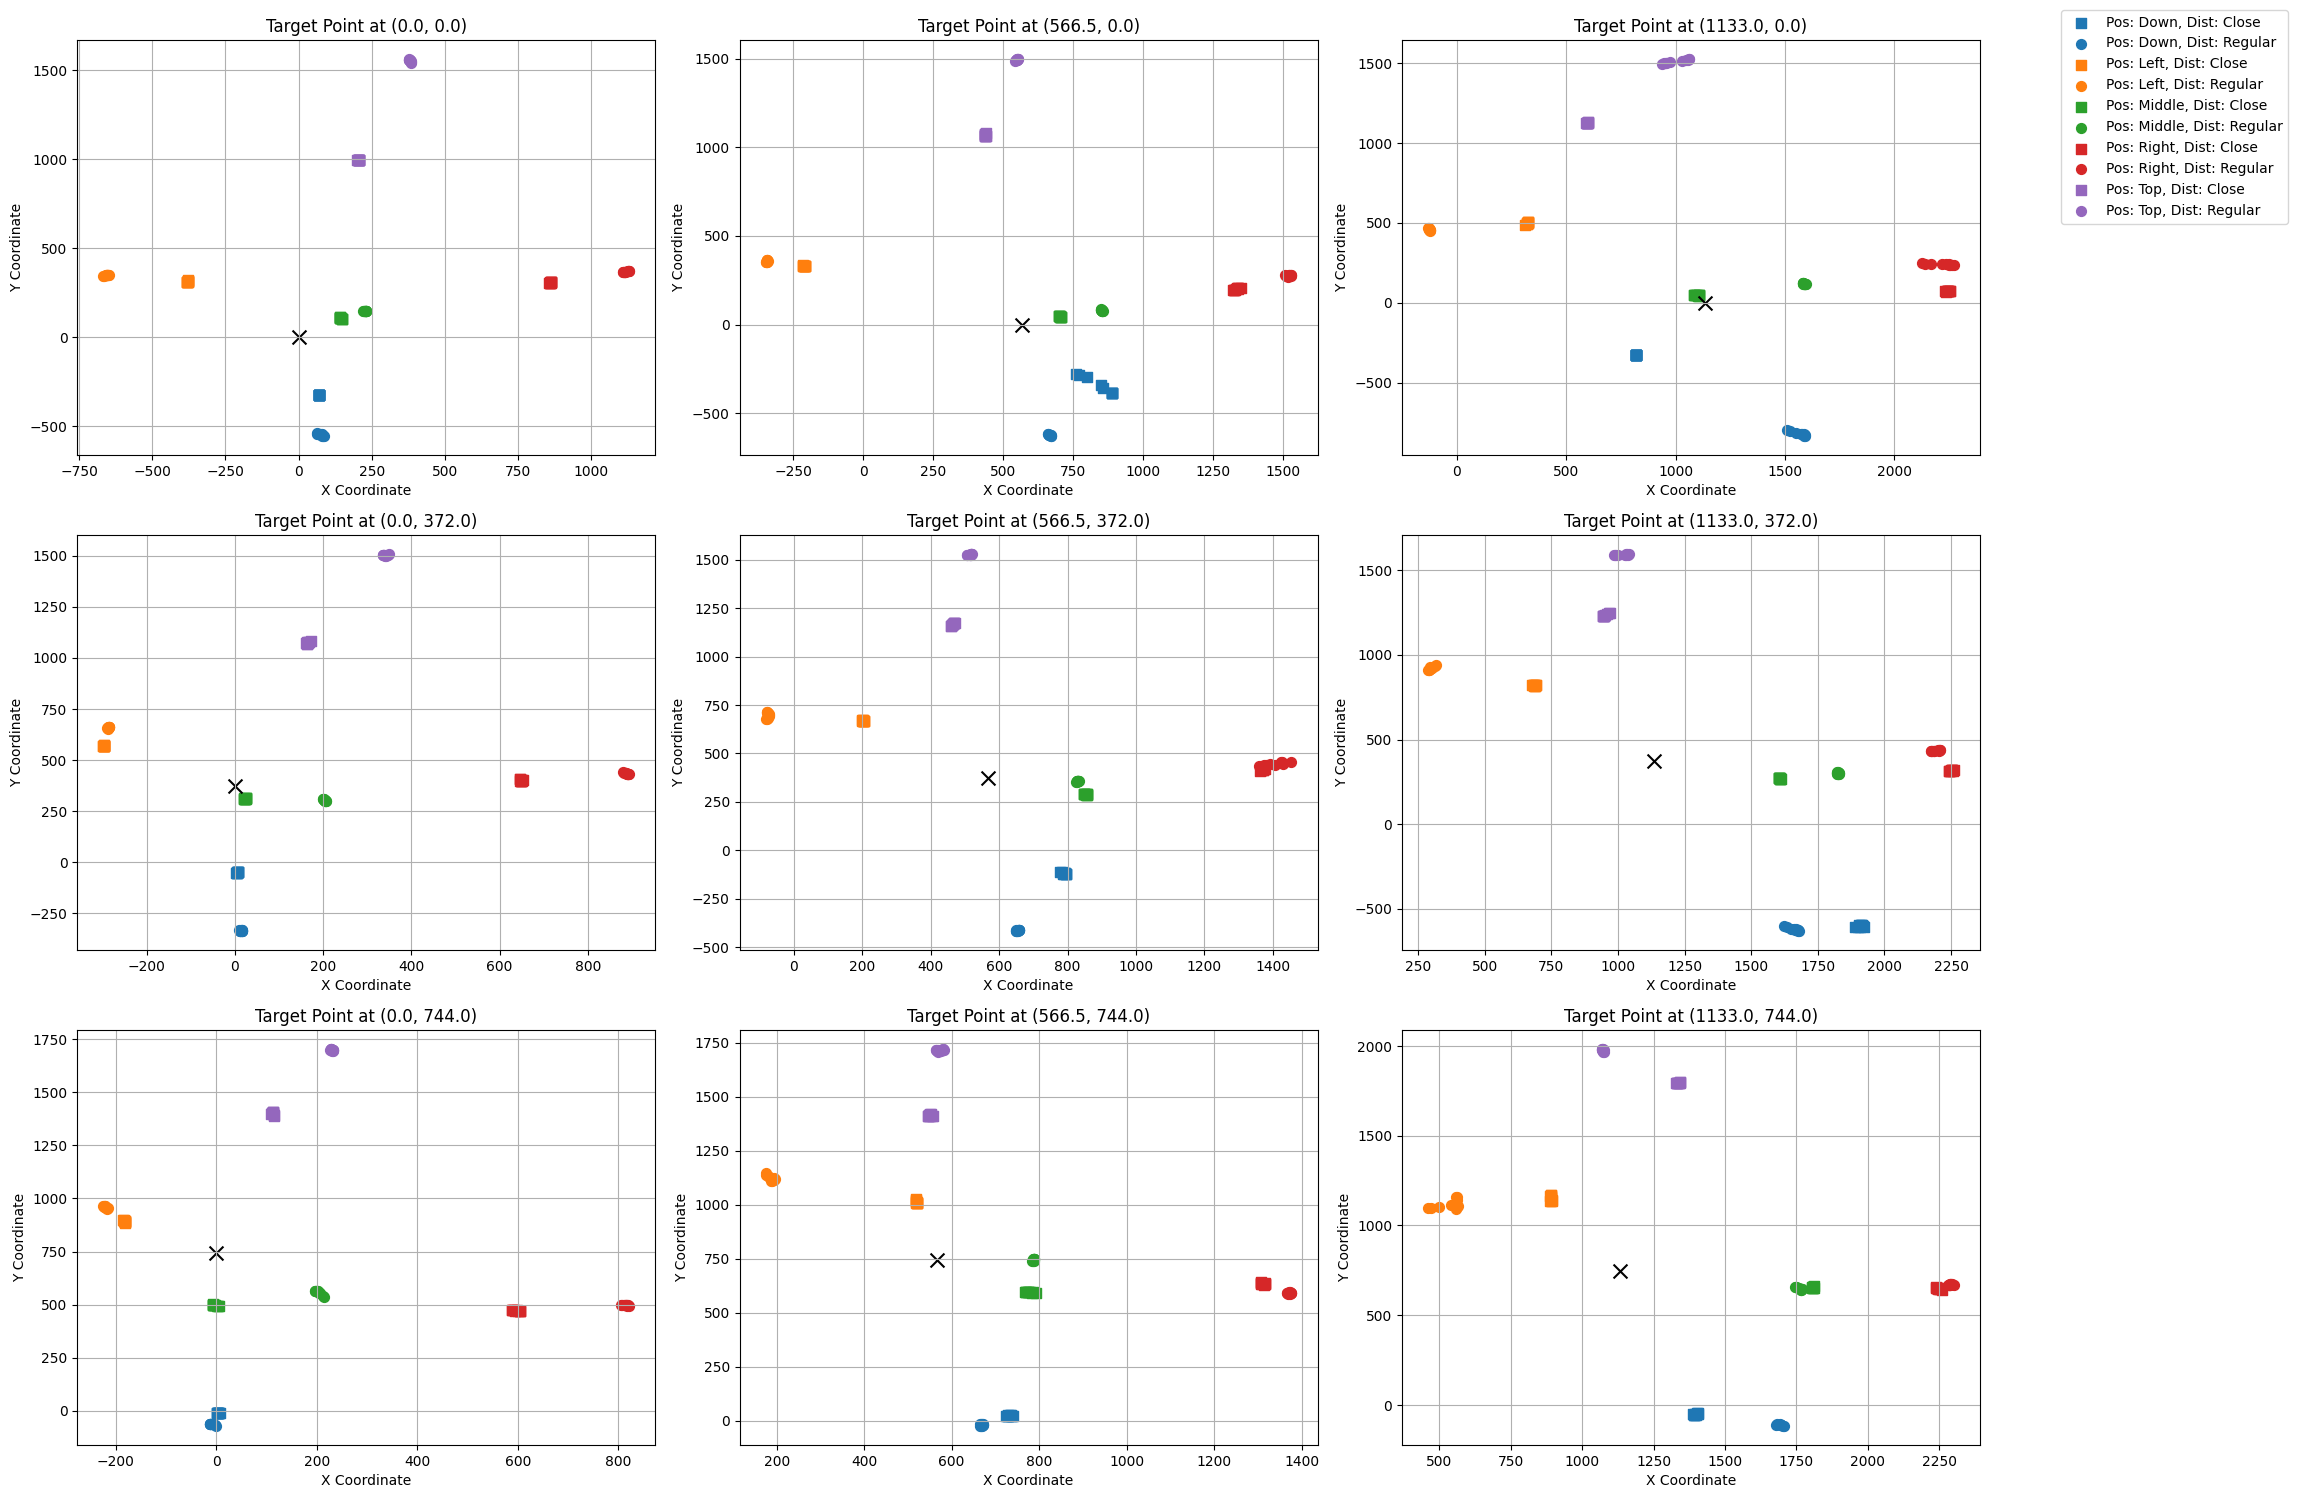

In [4]:
show_subplots(df)

## Average Offset Calibrator

In [5]:
aoc = AverageOffsetCalibrator(calib_data)

Compare for each gaze point in the data and their corresponding target point, what we got as a calibrated point.

In [6]:
new_columns = df.apply(
    lambda row: aoc.calibrate((row["gazePointX"], row["gazePointY"])),
    axis=1,
    result_type="expand",
)

# Assign new column names to the resulting DataFrame
new_columns.columns = ["calibratedPointX", "calibratedPointY"]

aoc_df = pd.concat([df, new_columns], axis=1)

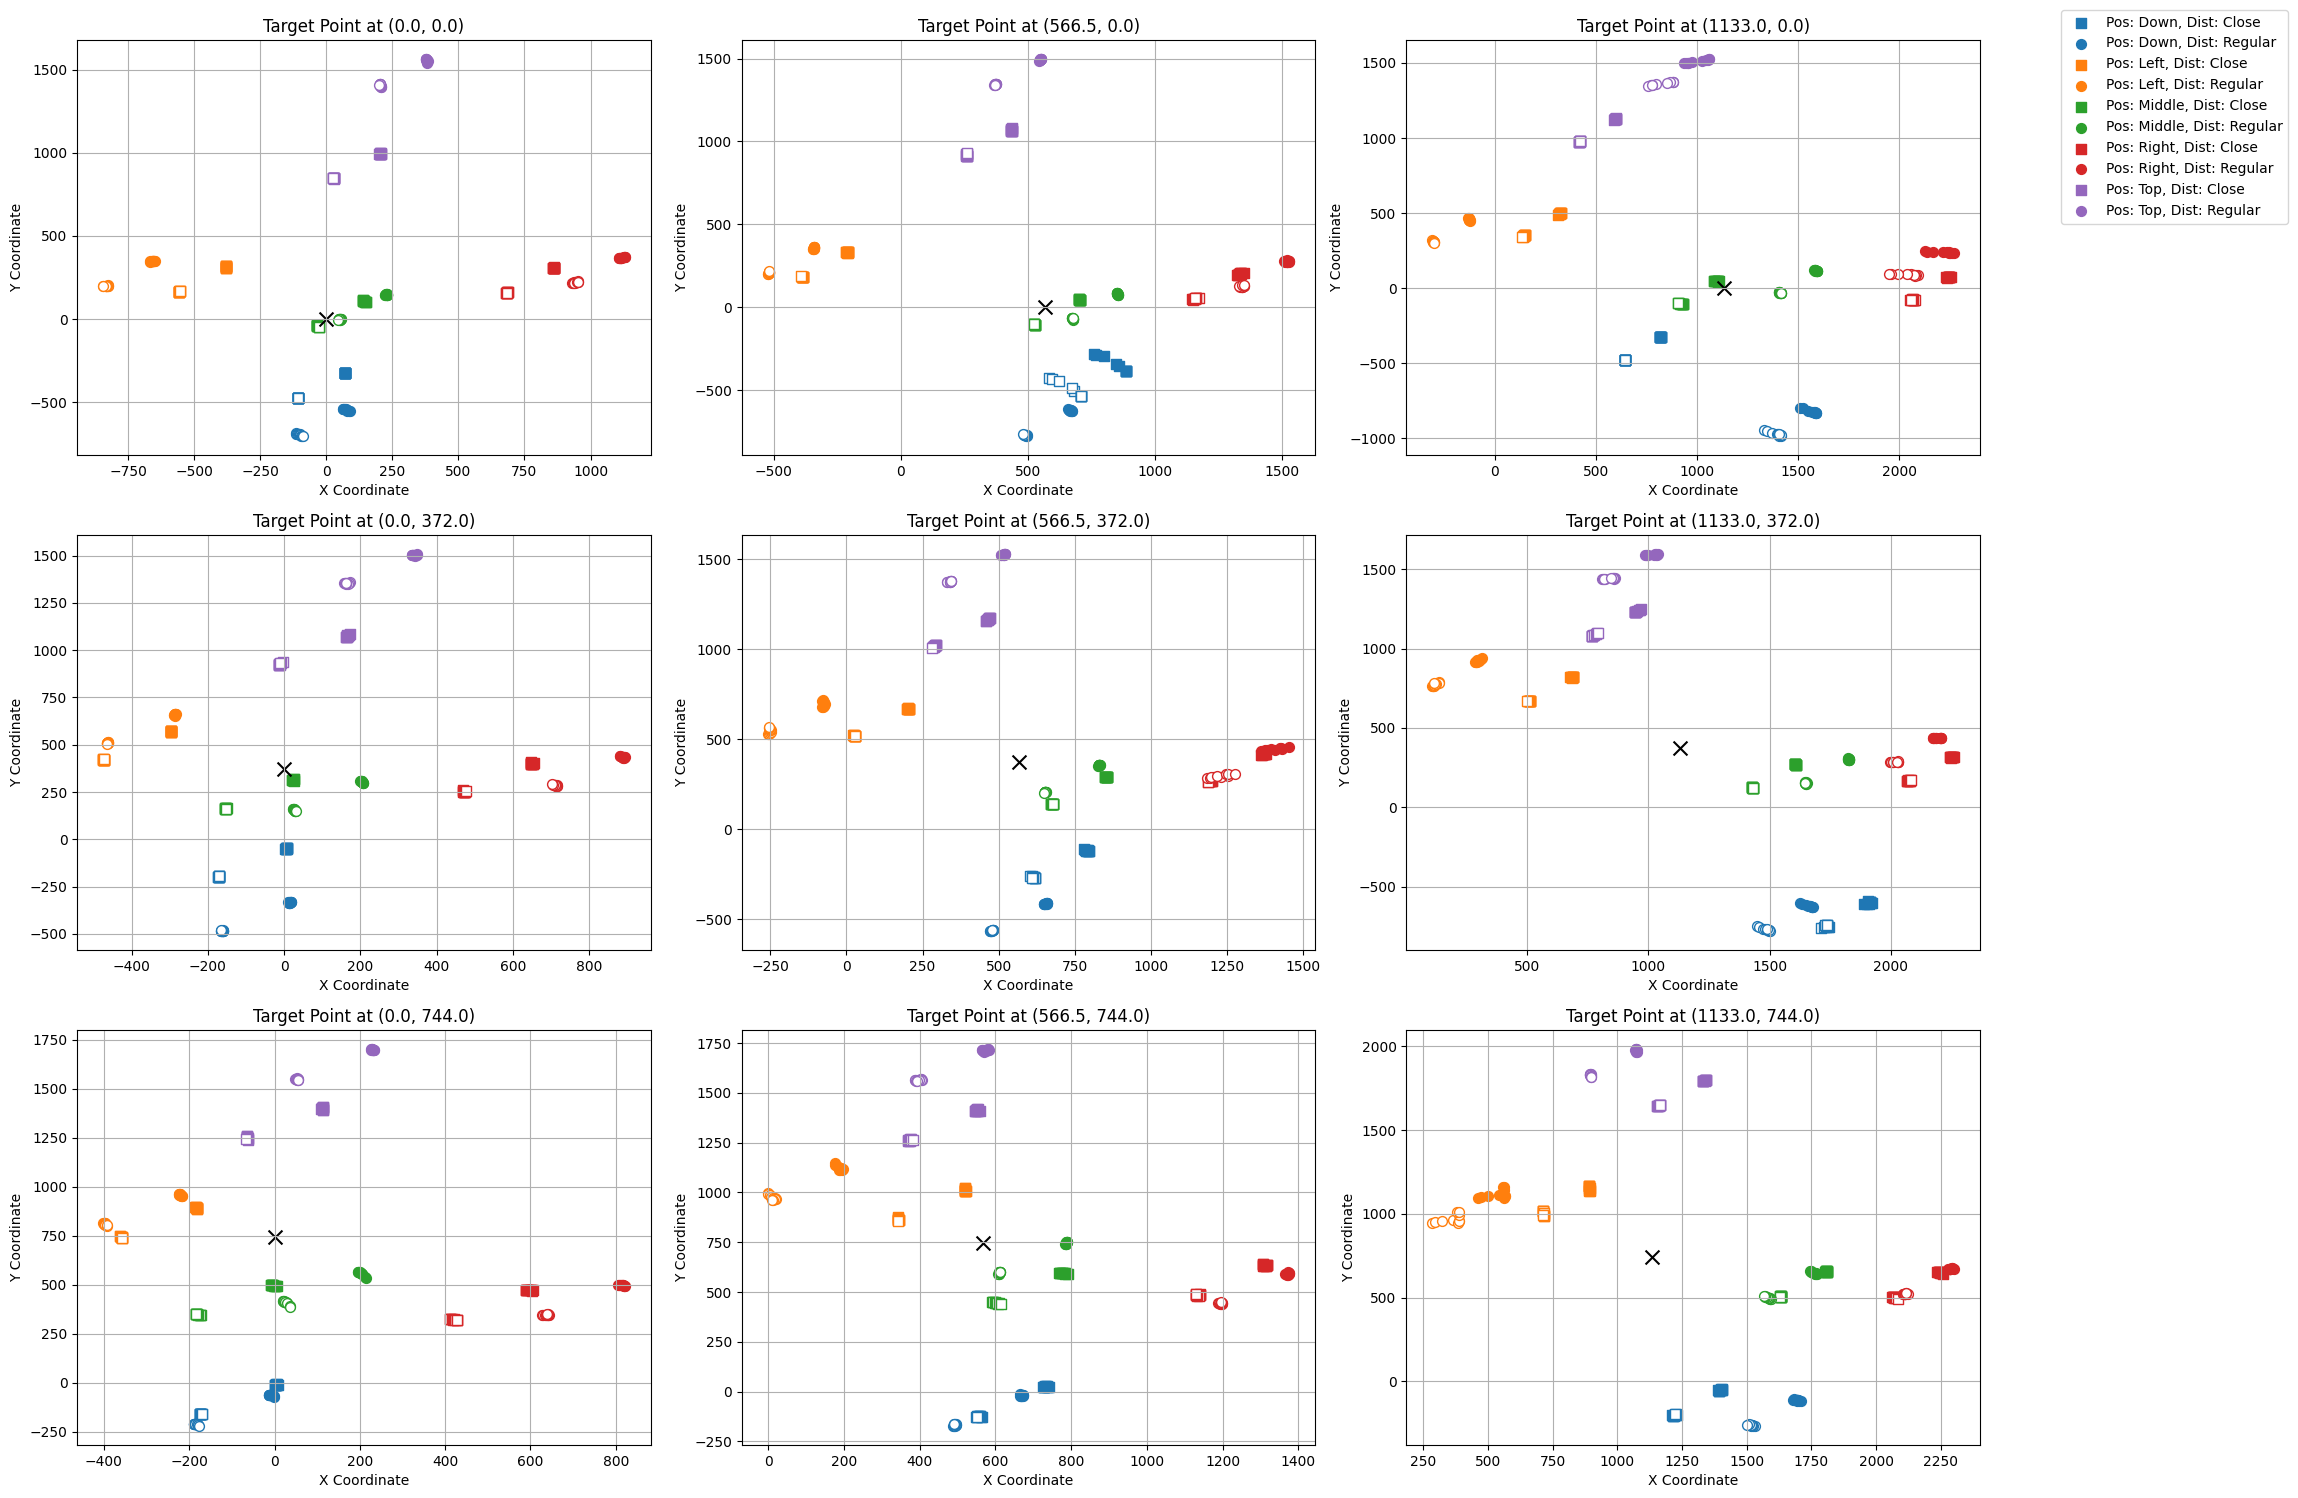

In [7]:
show_subplots(aoc_df, with_calib=True)

## Weighted Average Offset Calibrator

Weights the offset by how straight the face is. The more the face is straight, the more the offset is considered.

In [8]:
woc = WeightedOffsetCalibrator(calib_data)

In [9]:
new_columns = df.apply(
    lambda row: woc.calibrate((row["gazePointX"], row["gazePointY"])),
    axis=1,
    result_type="expand",
)

# Assign new column names to the resulting DataFrame
new_columns.columns = ["calibratedPointX", "calibratedPointY"]

woc_df = pd.concat([df, new_columns], axis=1)

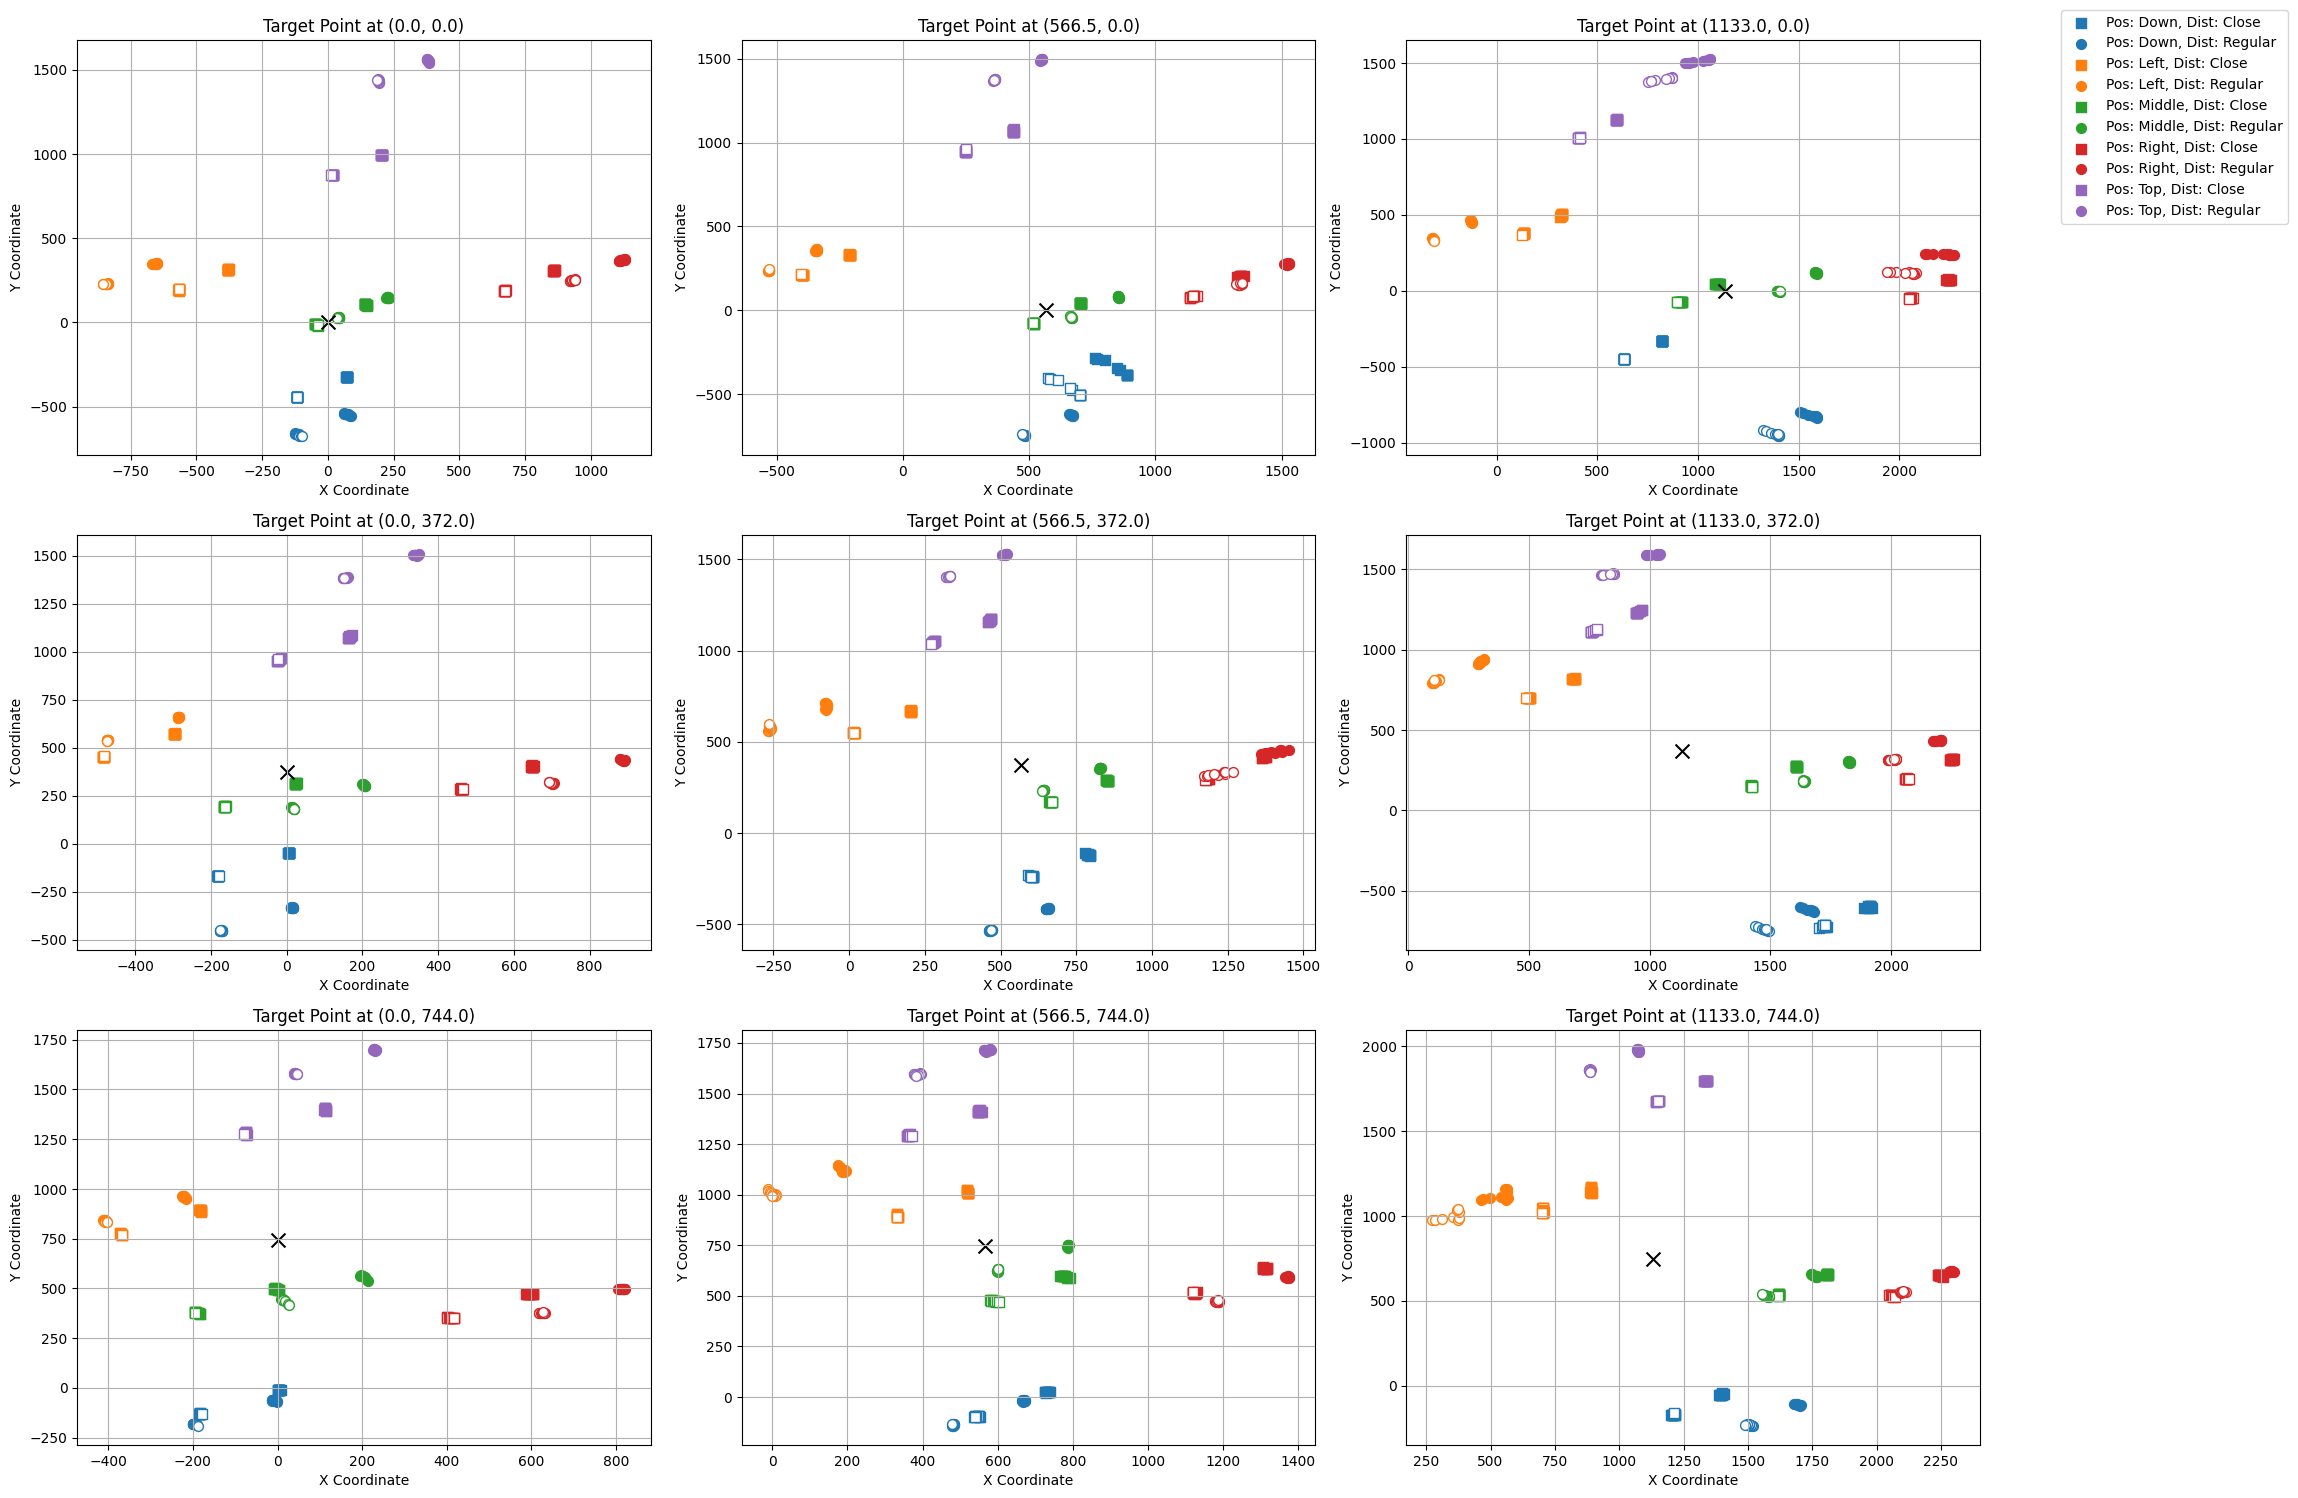

In [10]:
show_subplots(woc_df, with_calib=True)

## Linear Regression

### Setup

In [11]:
# Dropping the 'timestamp' column as it's not needed for the median calculation
# data = df.drop(columns="timestamp")

# List of columns to group by
group_columns = [
    "username",
    "deviceName",
    "position",
    "distance",
    "targetPointX",
    "targetPointY",
]

# Columns to compute the median
# Exclude group columns and any other non-required columns (like 'timestamp')
median_columns = [col for col in df.columns if col not in group_columns]

# Grouping by specified columns and computing the median of the rest of the columns
grouped_data = df.groupby(group_columns)[median_columns].median().reset_index()

display(grouped_data.head())

,username,deviceName,position,distance,targetPointX,targetPointY,timestamp,gazePointX,gazePointY,faceTransform_0_x,...,leftEyeTransform_3_x,leftEyeTransform_3_y,leftEyeTransform_3_z,leftEyeTransform_3_w,lookAtPointX,lookAtPointY,lookAtPointZ,roll,pitch,yaw
0,victor,iPad Mini 6th,Down,Close,0.0,0.0,1.715694e+09,70.988760,-324.538195,0.998787,...,0.031738,0.029988,0.024180,1.0,-0.207724,0.145160,0.870479,-19.190293,1.007004,-2.635080
1,victor,iPad Mini 6th,Down,Close,0.0,372.0,1.715694e+09,5.810137,-48.642838,0.998952,...,0.032182,0.031637,0.023821,1.0,-0.212063,0.074501,0.836008,-10.586718,2.618074,-0.141696
2,victor,iPad Mini 6th,Down,Close,0.0,744.0,1.715694e+09,3.500565,-9.812429,0.997390,...,0.032198,0.031979,0.023494,1.0,-0.197576,0.160285,0.890163,-12.971371,4.016960,0.998458
3,victor,iPad Mini 6th,Down,Close,566.5,0.0,1.715694e+09,873.400326,-371.883272,0.999518,...,0.031631,0.028292,0.024956,1.0,0.112326,0.096527,0.742844,-19.847600,-0.524636,-1.707931
4,victor,iPad Mini 6th,Down,Close,566.5,372.0,1.715694e+09,791.603750,-119.648882,0.998964,...,0.032214,0.031813,0.023788,1.0,0.117347,0.118060,0.841723,-14.116672,2.550149,0.581315


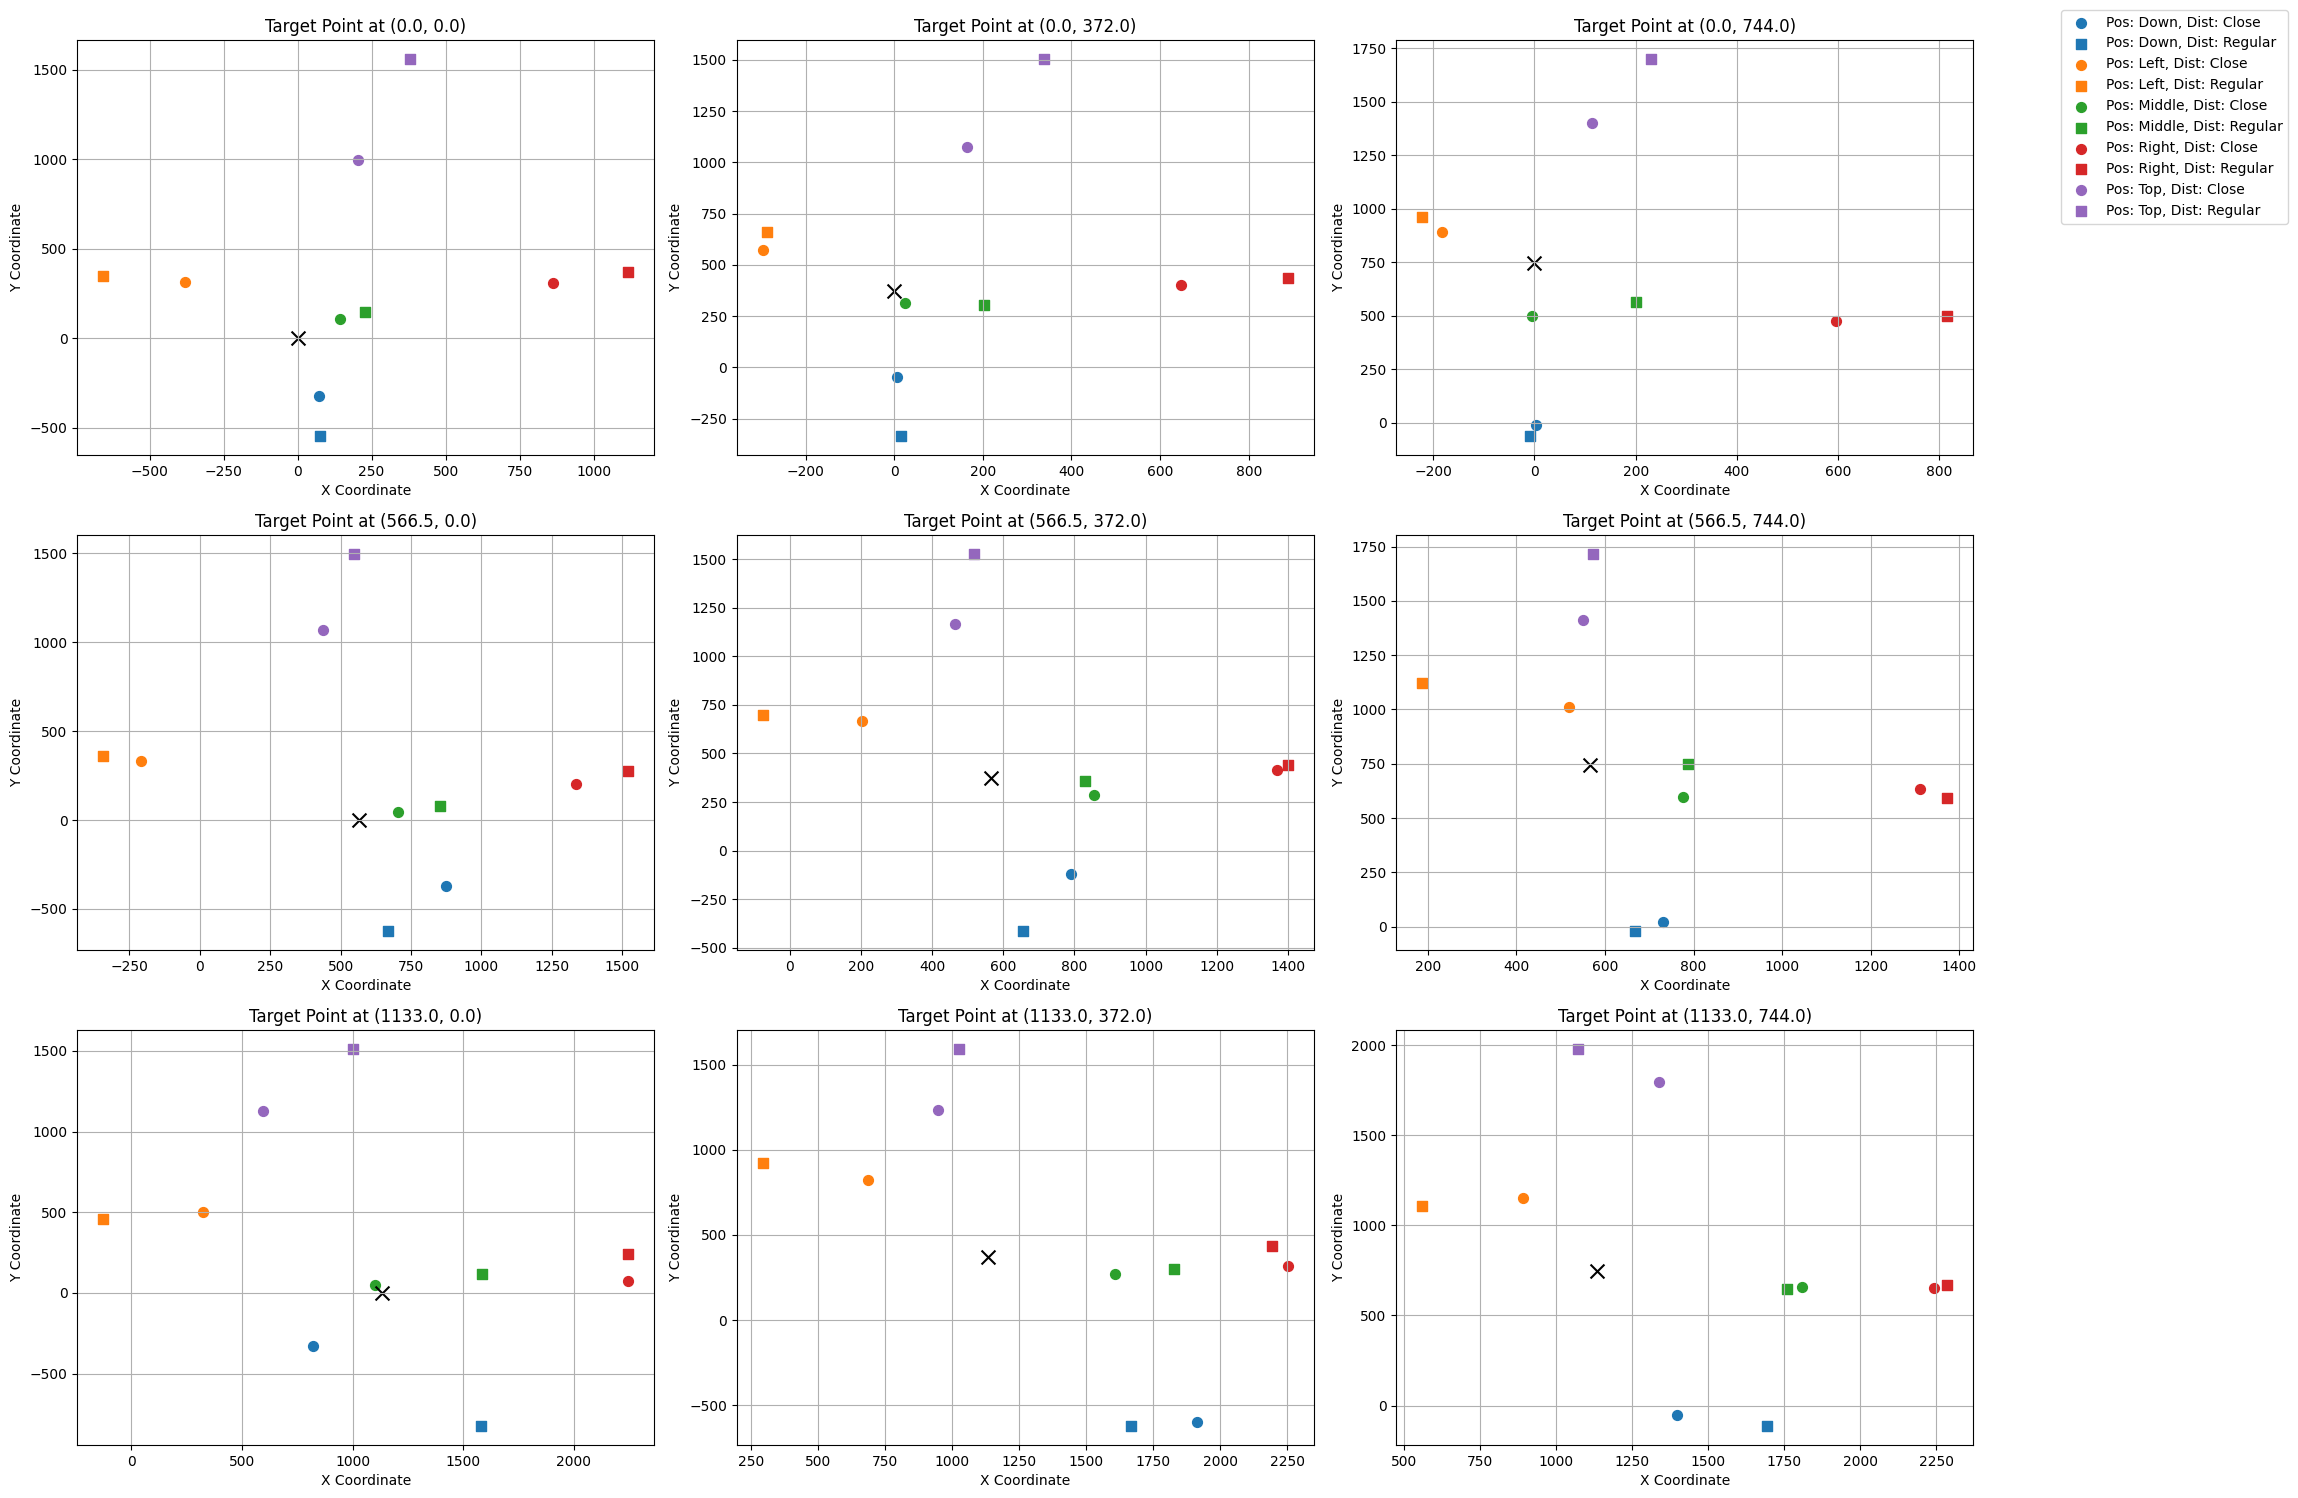

In [12]:
show_subplots(grouped_data)

In [13]:
grouped_calib_data = import_from_dataframe(grouped_data)
print(grouped_calib_data[0])

CalibrationData(username='victor', device_name='iPad Mini 6th', position=<HeadPosition.DOWN: 'Down'>, distance=<PositionToScreen.CLOSE: 'Close'>, timestamp=1715694344.8462515, target_point=(0.0, 0.0), gaze_point=(70.98875954512536, -324.5381952779969), face_transform=array([[ 0.9987874 ,  0.0376851 ,  0.03176365,  0.        ],
       [-0.0459676 ,  0.94369242,  0.32760049,  0.        ],
       [-0.01757462, -0.32865684,  0.94428898,  0.        ],
       [ 0.08613106, -0.05171058, -0.24211087,  1.0000001 ]]), right_eye_transform=array([[ 0.9790554 ,  0.02689365,  0.2018097 ,  0.        ],
       [ 0.        ,  0.9912371 , -0.13209465,  0.        ],
       [-0.20359376,  0.12932798,  0.97047603,  0.        ],
       [-0.03173006,  0.02996275,  0.02414582,  1.        ]]), left_eye_transform=array([[ 0.9622229 ,  0.03535037,  0.26995835,  0.        ],
       [ 0.        ,  0.99153507, -0.12983902,  0.        ],
       [-0.27226305,  0.12493407,  0.9540777 ,  0.        ],
       [ 0.0317378

### Test using all points

In [14]:
def features_with_face_transform(data):
    return list(data.gaze_point) + list(data.face_transform.flatten())

In [15]:
lrc = LinearRegressionCalibrator(
    grouped_calib_data,
    features_with_face_transform,
)

In [16]:
new_columns = grouped_data.apply(
    lambda row: lrc.calibrate(
        list((row["gazePointX"], row["gazePointY"]))
        + list(extract_face_transform(row).flatten())
    ),
    axis=1,
    result_type="expand",
)

# Assign new column names to the resulting DataFrame
new_columns.columns = ["calibratedPointX", "calibratedPointY"]

lrc_df = pd.concat([grouped_data, new_columns], axis=1)

display(lrc_df.head())

,username,deviceName,position,distance,targetPointX,targetPointY,timestamp,gazePointX,gazePointY,faceTransform_0_x,...,leftEyeTransform_3_z,leftEyeTransform_3_w,lookAtPointX,lookAtPointY,lookAtPointZ,roll,pitch,yaw,calibratedPointX,calibratedPointY
0,victor,iPad Mini 6th,Down,Close,0.0,0.0,1.715694e+09,70.988760,-324.538195,0.998787,...,0.024180,1.0,-0.207724,0.145160,0.870479,-19.190293,1.007004,-2.635080,-9.536743e-07,0.000000
1,victor,iPad Mini 6th,Down,Close,0.0,372.0,1.715694e+09,5.810137,-48.642838,0.998952,...,0.023821,1.0,-0.212063,0.074501,0.836008,-10.586718,2.618074,-0.141696,-9.163930e+01,416.241796
2,victor,iPad Mini 6th,Down,Close,0.0,744.0,1.715694e+09,3.500565,-9.812429,0.997390,...,0.023494,1.0,-0.197576,0.160285,0.890163,-12.971371,4.016960,0.998458,-1.701516e+01,690.690954
3,victor,iPad Mini 6th,Down,Close,566.5,0.0,1.715694e+09,873.400326,-371.883272,0.999518,...,0.024956,1.0,0.112326,0.096527,0.742844,-19.847600,-0.524636,-1.707931,9.290046e+02,-56.654552
4,victor,iPad Mini 6th,Down,Close,566.5,372.0,1.715694e+09,791.603750,-119.648882,0.998964,...,0.023788,1.0,0.117347,0.118060,0.841723,-14.116672,2.550149,0.581315,5.354546e+02,508.353729


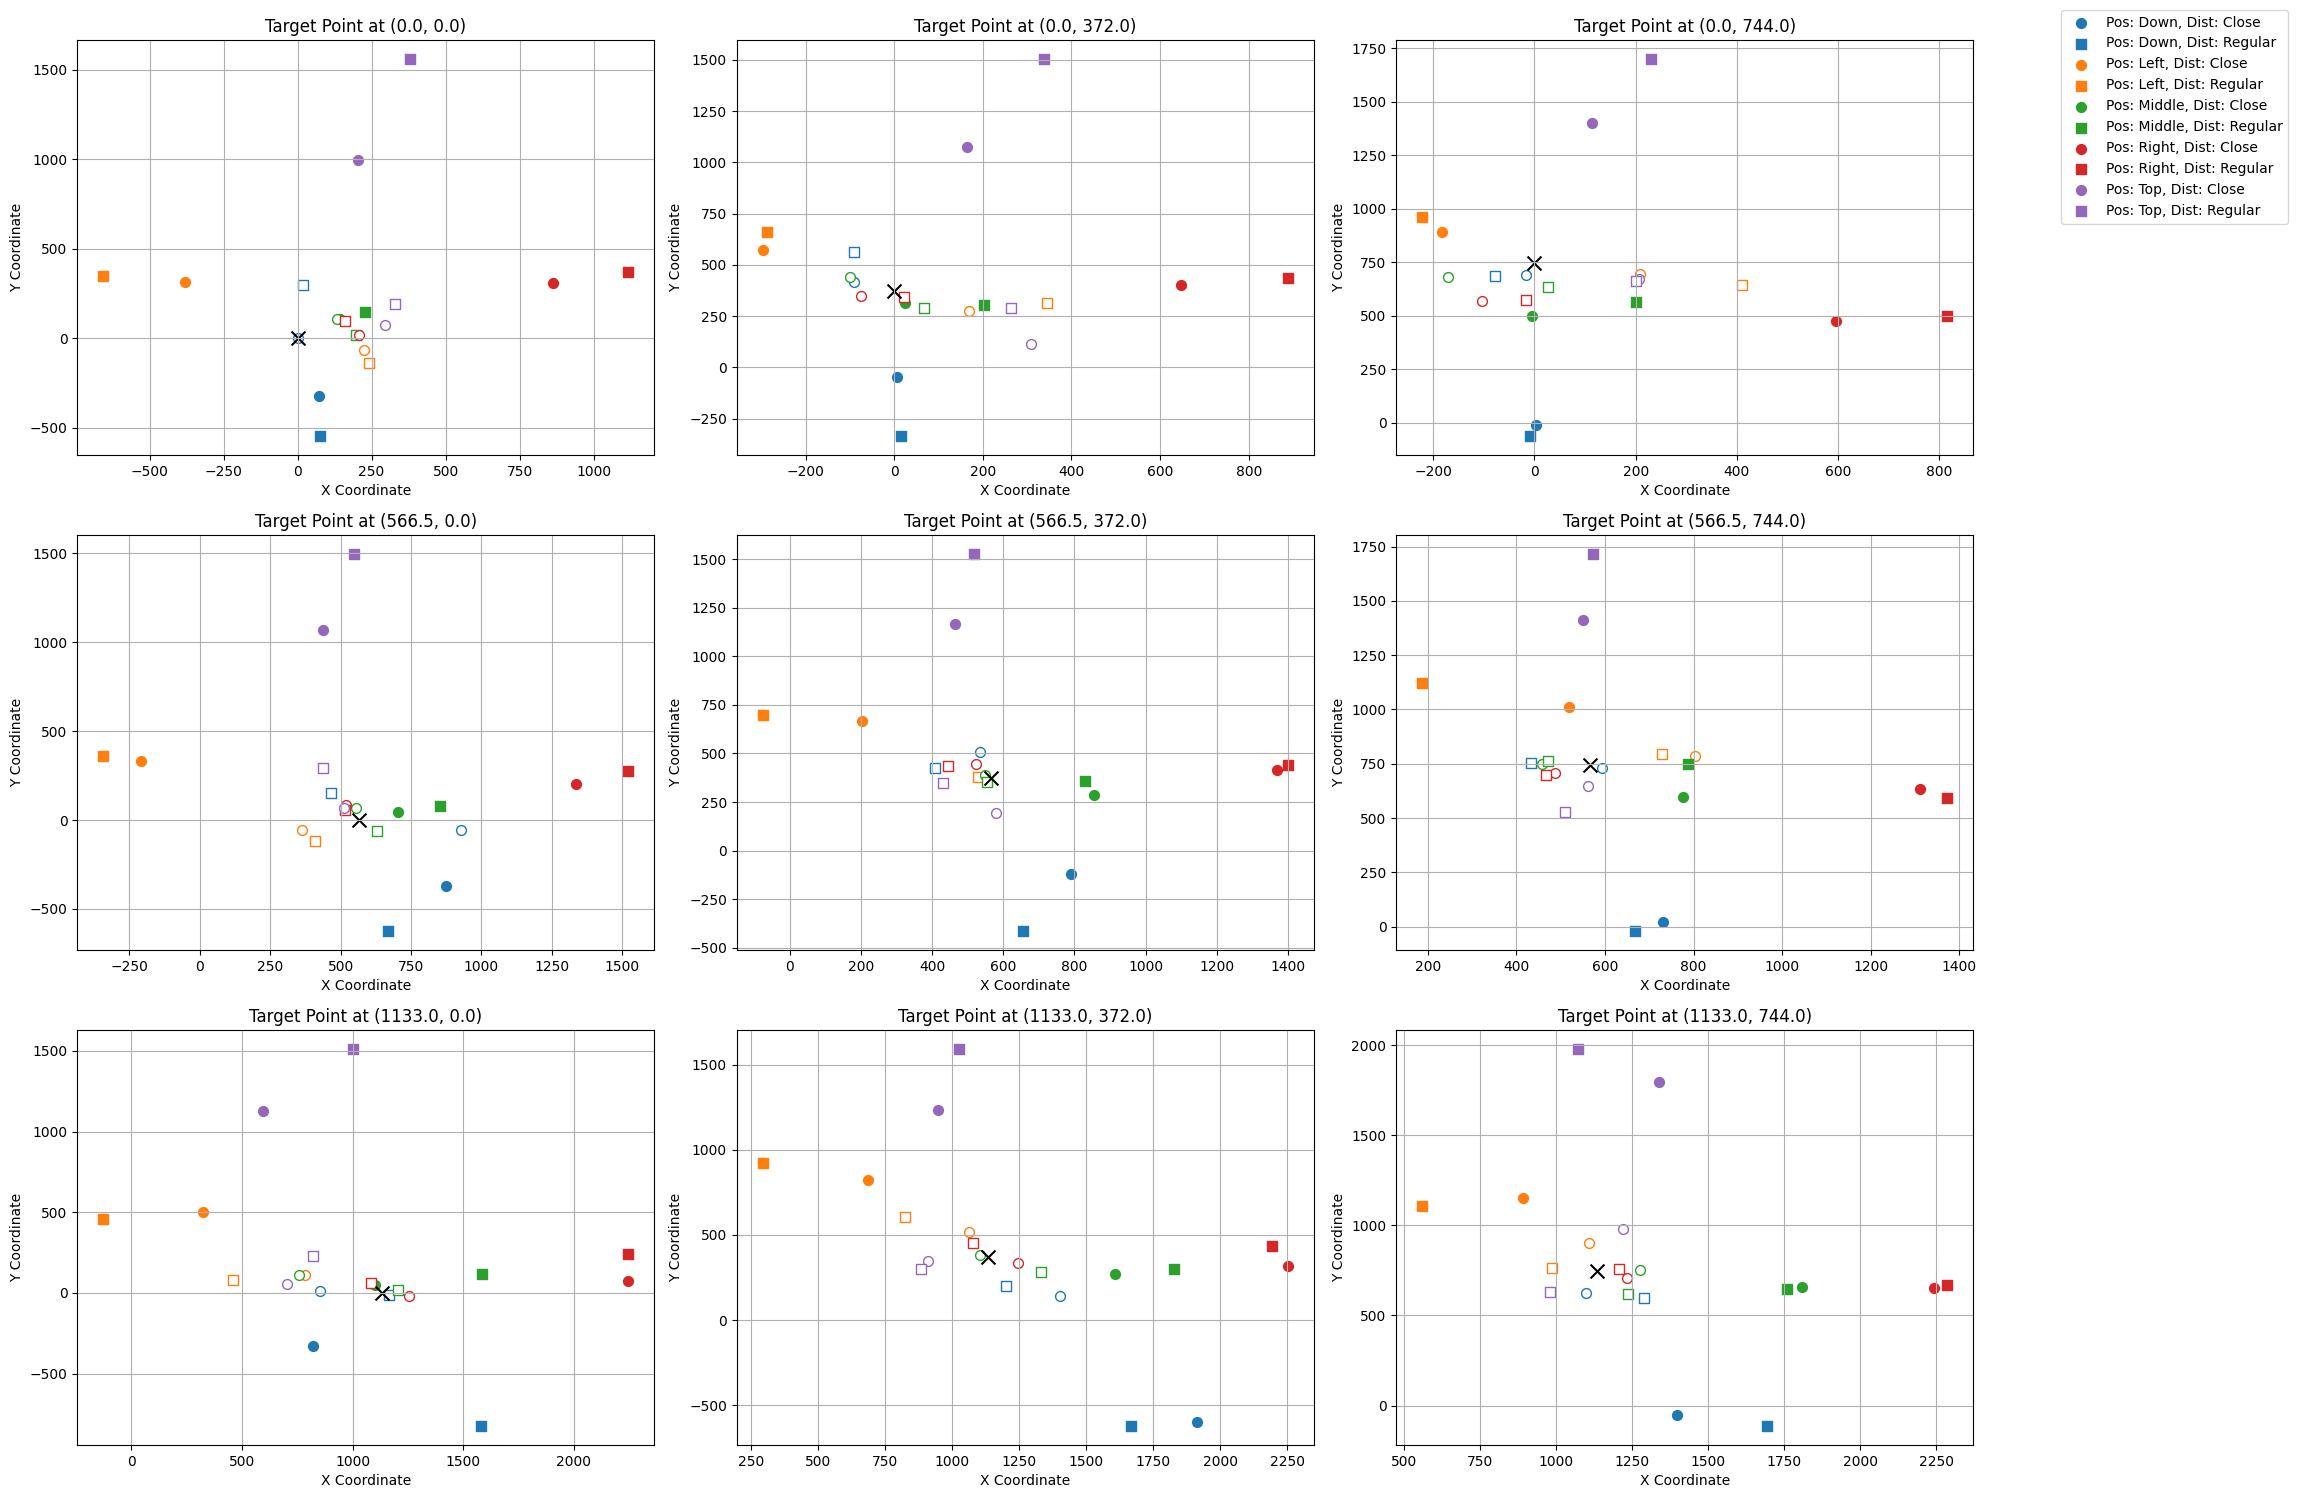

In [17]:
show_subplots(lrc_df, with_calib=True)

### Test using subset of points to test

#### Split in trainset and testing set

In [18]:
stratify_labels = [
    f"{cd.target_point[0]}_{cd.target_point[1]}" for cd in grouped_calib_data
]

# Check distribution of stratification labels to ensure there's enough data for each category
label_distribution = Counter(stratify_labels)
print("Label Distribution:", label_distribution)

# It's important that no label has too few samples to be split correctly
# Adjust `min_count` based on your data size and the results of the distribution printout
min_count = 3
valid_indices = [
    i
    for i, label in enumerate(stratify_labels)
    if label_distribution[label] >= min_count
]

# Filter data and labels to include only those that have enough samples
filtered_data = [grouped_calib_data[i] for i in valid_indices]
filtered_labels = [stratify_labels[i] for i in valid_indices]

# Split data using train_test_split from scikit-learn, stratifying by the filtered labels
train_data, test_data = train_test_split(
    filtered_data, test_size=0.3, stratify=filtered_labels, random_state=42
)

# Create the df for later
train_df = calib_data_to_dataframe(train_data)
test_df = calib_data_to_dataframe(test_data)

print("Training Data Length:", len(train_data))
print("Testing Data Length:", len(test_data))

Label Distribution: Counter({'0.0_0.0': 10, '0.0_372.0': 10, '0.0_744.0': 10, '566.5_0.0': 10, '566.5_372.0': 10, '566.5_744.0': 10, '1133.0_0.0': 10, '1133.0_372.0': 10, '1133.0_744.0': 10})
Training Data Length: 63
Testing Data Length: 27


In [19]:
# display for down close and target 0 0
display(train_df[(train_df["targetPointX"] == 0) & (train_df["targetPointY"] == 0)])

,username,deviceName,position,distance,timestamp,targetPointX,targetPointY,gazePointX,gazePointY,faceTransform_0_x,...,leftEyeTransform_3_x,leftEyeTransform_3_y,leftEyeTransform_3_z,leftEyeTransform_3_w,roll,pitch,yaw,lookAtPointX,lookAtPointY,lookAtPointZ
5,victor,iPad Mini 6th,Left,Close,1.715694e+09,0.0,0.0,-379.586625,312.477630,0.901022,...,0.032543,0.032169,0.024011,1.0,13.470158,25.646846,1.847213,0.118629,-0.206684,0.869186
6,victor,iPad Mini 6th,Down,Close,1.715694e+09,0.0,0.0,70.988760,-324.538195,0.998787,...,0.031738,0.029988,0.024180,1.0,-19.190293,1.007004,-2.635080,-0.207724,0.145160,0.870479
13,victor,iPad Mini 6th,Down,Regular,1.715694e+09,0.0,0.0,76.330762,-544.746006,0.999474,...,0.031436,0.030845,0.024322,1.0,-18.421913,0.989197,1.576138,-0.164991,0.158839,0.936813
21,victor,iPad Mini 6th,Right,Regular,1.715694e+09,0.0,0.0,1116.811799,369.409151,0.888402,...,0.031588,0.031517,0.023837,1.0,8.779772,-27.316023,0.791024,-0.635628,-0.229583,1.038432
24,victor,iPad Mini 6th,Middle,Regular,1.715694e+09,0.0,0.0,228.616358,146.866648,0.999917,...,0.031501,0.030555,0.025464,1.0,1.343339,-0.688437,0.270749,-0.107342,-0.088831,0.935603
35,victor,iPad Mini 6th,Top,Regular,1.715694e+09,0.0,0.0,379.571205,1558.198711,0.997671,...,0.031525,0.030644,0.025155,1.0,34.568981,-1.772286,-3.509759,-0.159184,-0.444745,0.977433
37,victor,iPad Mini 6th,Top,Close,1.715694e+09,0.0,0.0,204.999402,995.463555,0.998738,...,0.031817,0.031196,0.023952,1.0,33.726751,1.470829,-2.473598,-0.147239,-0.317511,0.886332


In [20]:
display(test_df.head())

,username,deviceName,position,distance,timestamp,targetPointX,targetPointY,gazePointX,gazePointY,faceTransform_0_x,...,leftEyeTransform_3_x,leftEyeTransform_3_y,leftEyeTransform_3_z,leftEyeTransform_3_w,roll,pitch,yaw,lookAtPointX,lookAtPointY,lookAtPointZ
0,victor,iPad Mini 6th,Left,Regular,1.715694e+09,0.0,0.0,-655.791091,349.482134,0.800414,...,0.031695,0.031207,0.024200,1.0,6.186562,36.734408,-2.859182,0.469521,-0.135954,0.962937
1,victor,iPad Mini 6th,Middle,Close,1.715694e+09,1133.0,744.0,1808.426258,655.613619,0.999911,...,0.031817,0.031196,0.023952,1.0,1.066528,0.759848,0.073083,0.599035,0.164181,0.867825
2,victor,iPad Mini 6th,Middle,Regular,1.715694e+09,1133.0,0.0,1586.850165,116.952605,0.999884,...,0.031448,0.030451,0.025512,1.0,-0.364283,-0.767425,0.416353,0.208708,-0.061813,0.984702
3,victor,iPad Mini 6th,Top,Regular,1.715694e+09,566.5,0.0,548.638776,1493.955594,0.996718,...,0.031525,0.030644,0.025155,1.0,33.900023,-2.074320,-4.155998,-0.130180,-0.437656,0.969204
4,victor,iPad Mini 6th,Down,Regular,1.715694e+09,0.0,744.0,-9.589606,-62.401205,0.999364,...,0.031463,0.030787,0.024253,1.0,-14.844797,1.122349,1.697799,-0.190054,0.205339,0.955650


#### Test

We have to remember that the gaze points we computed were not really close either to the target points. 
Let's compute the errors for the test set without the calibration and then we will see if we got any improvement.

In [21]:
# extract the target points and their gaze points
target_points = np.array([cd.target_point for cd in calib_data])
gaze_points = np.array([cd.gaze_point for cd in calib_data])

mse = mean_squared_error(target_points, gaze_points)
evaluation_without_calib = {
    "MSE": mse,
    "RMSE": np.sqrt(mse),
    "R2": r2_score(target_points, gaze_points),
}
print(evaluation_without_calib)

{'MSE': 336955.4639141604, 'RMSE': 580.4786506962683, 'R2': -1.728317695233347}


##### Test on split data with face transform in features

In [22]:
split_lrc = LinearRegressionCalibrator(train_data, features_with_face_transform)

Let's evaluate on our test set:

In [23]:
evaluation_test = split_lrc.evaluate(test_data)
print(evaluation_test)

{'MSE': 34050.79611092948, 'RMSE': 184.52857803313142, 'R2': 0.7717365958327908}


In [24]:
# compare the two (two digit after .2f)
print(f"Difference in MSE:  {evaluation_test["MSE"] - evaluation_without_calib["MSE"]:.2f}")
print(f"Difference in RMSE: {evaluation_test["RMSE"] - evaluation_without_calib["RMSE"]:.2f}")
print(f"Difference in R2:   {evaluation_test["R2"] - evaluation_without_calib["R2"]:.2f}")

Difference in MSE:  -302904.67
Difference in RMSE: -395.95
Difference in R2:   2.50


We can see an improvement in the results calibrated.
Nonetheless, the accuracy is still far from perfect.

In [25]:
new_columns = test_df.apply(
    lambda row: split_lrc.calibrate(
        list((row["gazePointX"], row["gazePointY"]))
        + list(extract_face_transform(row).flatten())
    ),
    axis=1,
    result_type="expand",
)

# Assign new column names to the resulting DataFrame
new_columns.columns = ["calibratedPointX", "calibratedPointY"]

split_lrc_df = pd.concat([test_df, new_columns], axis=1)

display(
    split_lrc_df[
        (split_lrc_df["targetPointX"] == 0) & (split_lrc_df["targetPointY"] == 0)
    ]
)

,username,deviceName,position,distance,timestamp,targetPointX,targetPointY,gazePointX,gazePointY,faceTransform_0_x,...,leftEyeTransform_3_z,leftEyeTransform_3_w,roll,pitch,yaw,lookAtPointX,lookAtPointY,lookAtPointZ,calibratedPointX,calibratedPointY
0,victor,iPad Mini 6th,Left,Regular,1.715694e+09,0.0,0.0,-655.791091,349.482134,0.800414,...,0.024200,1.0,6.186562,36.734408,-2.859182,0.469521,-0.135954,0.962937,353.739861,-197.535623
22,victor,iPad Mini 6th,Middle,Close,1.715694e+09,0.0,0.0,141.810318,108.489420,0.999436,...,0.023883,1.0,4.608496,1.205460,-1.494051,-0.105536,-0.145282,0.639705,124.430707,130.539500
23,victor,iPad Mini 6th,Right,Close,1.715694e+09,0.0,0.0,861.114019,308.281538,0.942387,...,0.024060,1.0,12.091772,-19.537910,-0.410464,-0.523475,-0.241749,1.004017,323.612624,-14.552937


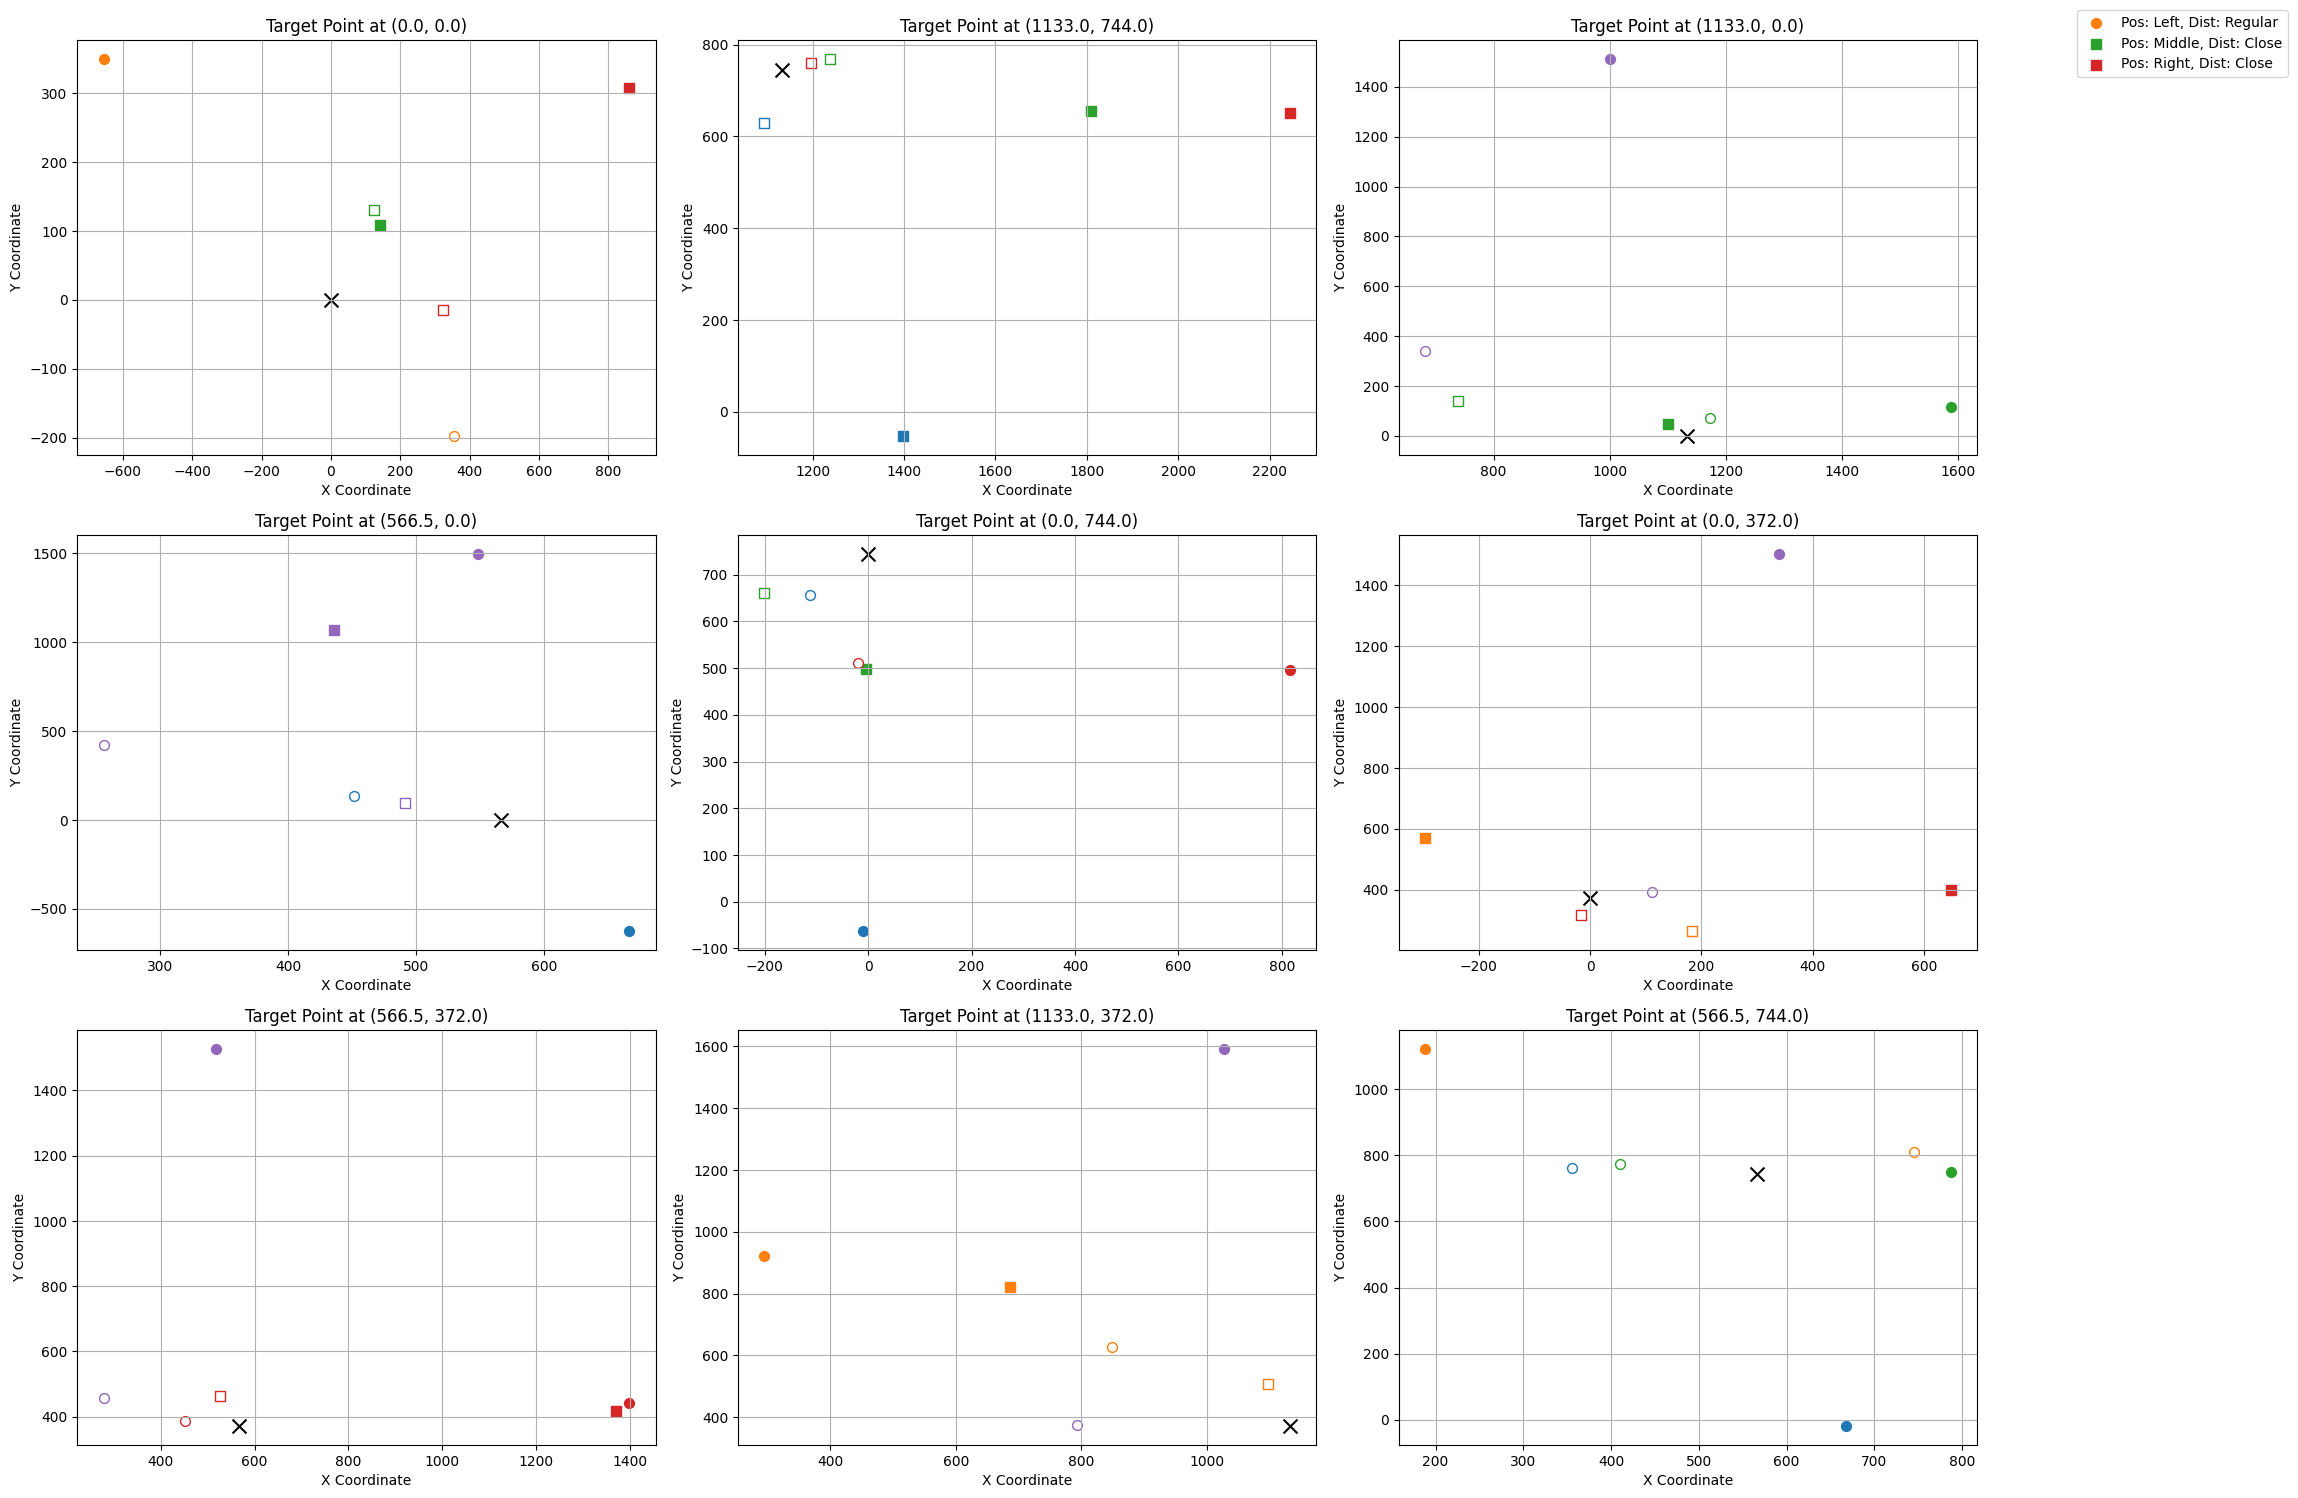

In [26]:
show_subplots(split_lrc_df, with_calib=True)

##### Test on split data with roll, pitch and yaw in features

In [27]:
def features_with_roll_pitch_yaw(data):
    return list(data.gaze_point) + list(data.euler_angles)

In [28]:
split_rpy_lrc = LinearRegressionCalibrator(train_data, features_with_roll_pitch_yaw)

Let's evaluate on our test set:

In [29]:
evaluation_rpy_test = split_rpy_lrc.evaluate(test_data)
print(evaluation_rpy_test)

{'MSE': 41897.87389139099, 'RMSE': 204.68970147858195, 'R2': 0.669333520955193}


In [30]:
# compare the two (two digit after .2f)
print(f"Difference in MSE:  {evaluation_rpy_test["MSE"] - evaluation_without_calib["MSE"]:.2f}")
print(f"Difference in RMSE: {evaluation_rpy_test["RMSE"] - evaluation_without_calib["RMSE"]:.2f}")
print(f"Difference in R2:   {evaluation_rpy_test["R2"] - evaluation_without_calib["R2"]:.2f}")

Difference in MSE:  -295057.59
Difference in RMSE: -375.79
Difference in R2:   2.40


Now let's compare with features of the entire face transform:  

In [31]:
# compare the two (two digit after .2f)
print(f"Difference in MSE:  {evaluation_rpy_test["MSE"] - evaluation_test["MSE"]:.2f}")
print(f"Difference in RMSE: {evaluation_rpy_test["RMSE"] - evaluation_test["RMSE"]:.2f}")
print(f"Difference in R2:   {evaluation_rpy_test["R2"] - evaluation_test["R2"]:.2f}")

Difference in MSE:  7847.08
Difference in RMSE: 20.16
Difference in R2:   -0.10


We can see an improvement in the results calibrated.
Nonetheless, the accuracy is still far from perfect.

In [32]:
new_columns = test_df.apply(
    lambda row: split_rpy_lrc.calibrate(
        list((row["gazePointX"], row["gazePointY"]))
        + list(extract_euler_angles_from_matrix(extract_face_transform(row)))
    ),
    axis=1,
    result_type="expand",
)

# Assign new column names to the resulting DataFrame
new_columns.columns = ["calibratedPointX", "calibratedPointY"]

split_rpy_lrc_df = pd.concat([test_df, new_columns], axis=1)

display(split_rpy_lrc_df.head())

,username,deviceName,position,distance,timestamp,targetPointX,targetPointY,gazePointX,gazePointY,faceTransform_0_x,...,leftEyeTransform_3_z,leftEyeTransform_3_w,roll,pitch,yaw,lookAtPointX,lookAtPointY,lookAtPointZ,calibratedPointX,calibratedPointY
0,victor,iPad Mini 6th,Left,Regular,1.715694e+09,0.0,0.0,-655.791091,349.482134,0.800414,...,0.024200,1.0,6.186562,36.734408,-2.859182,0.469521,-0.135954,0.962937,327.753318,39.155103
1,victor,iPad Mini 6th,Middle,Close,1.715694e+09,1133.0,744.0,1808.426258,655.613619,0.999911,...,0.023952,1.0,1.066528,0.759848,0.073083,0.599035,0.164181,0.867825,1320.100003,752.840789
2,victor,iPad Mini 6th,Middle,Regular,1.715694e+09,1133.0,0.0,1586.850165,116.952605,0.999884,...,0.025512,1.0,-0.364283,-0.767425,0.416353,0.208708,-0.061813,0.984702,1142.874631,302.968320
3,victor,iPad Mini 6th,Top,Regular,1.715694e+09,566.5,0.0,548.638776,1493.955594,0.996718,...,0.025155,1.0,33.900023,-2.074320,-4.155998,-0.130180,-0.437656,0.969204,431.588260,450.160473
4,victor,iPad Mini 6th,Down,Regular,1.715694e+09,0.0,744.0,-9.589606,-62.401205,0.999364,...,0.024253,1.0,-14.844797,1.122349,1.697799,-0.190054,0.205339,0.955650,-128.430956,509.018510


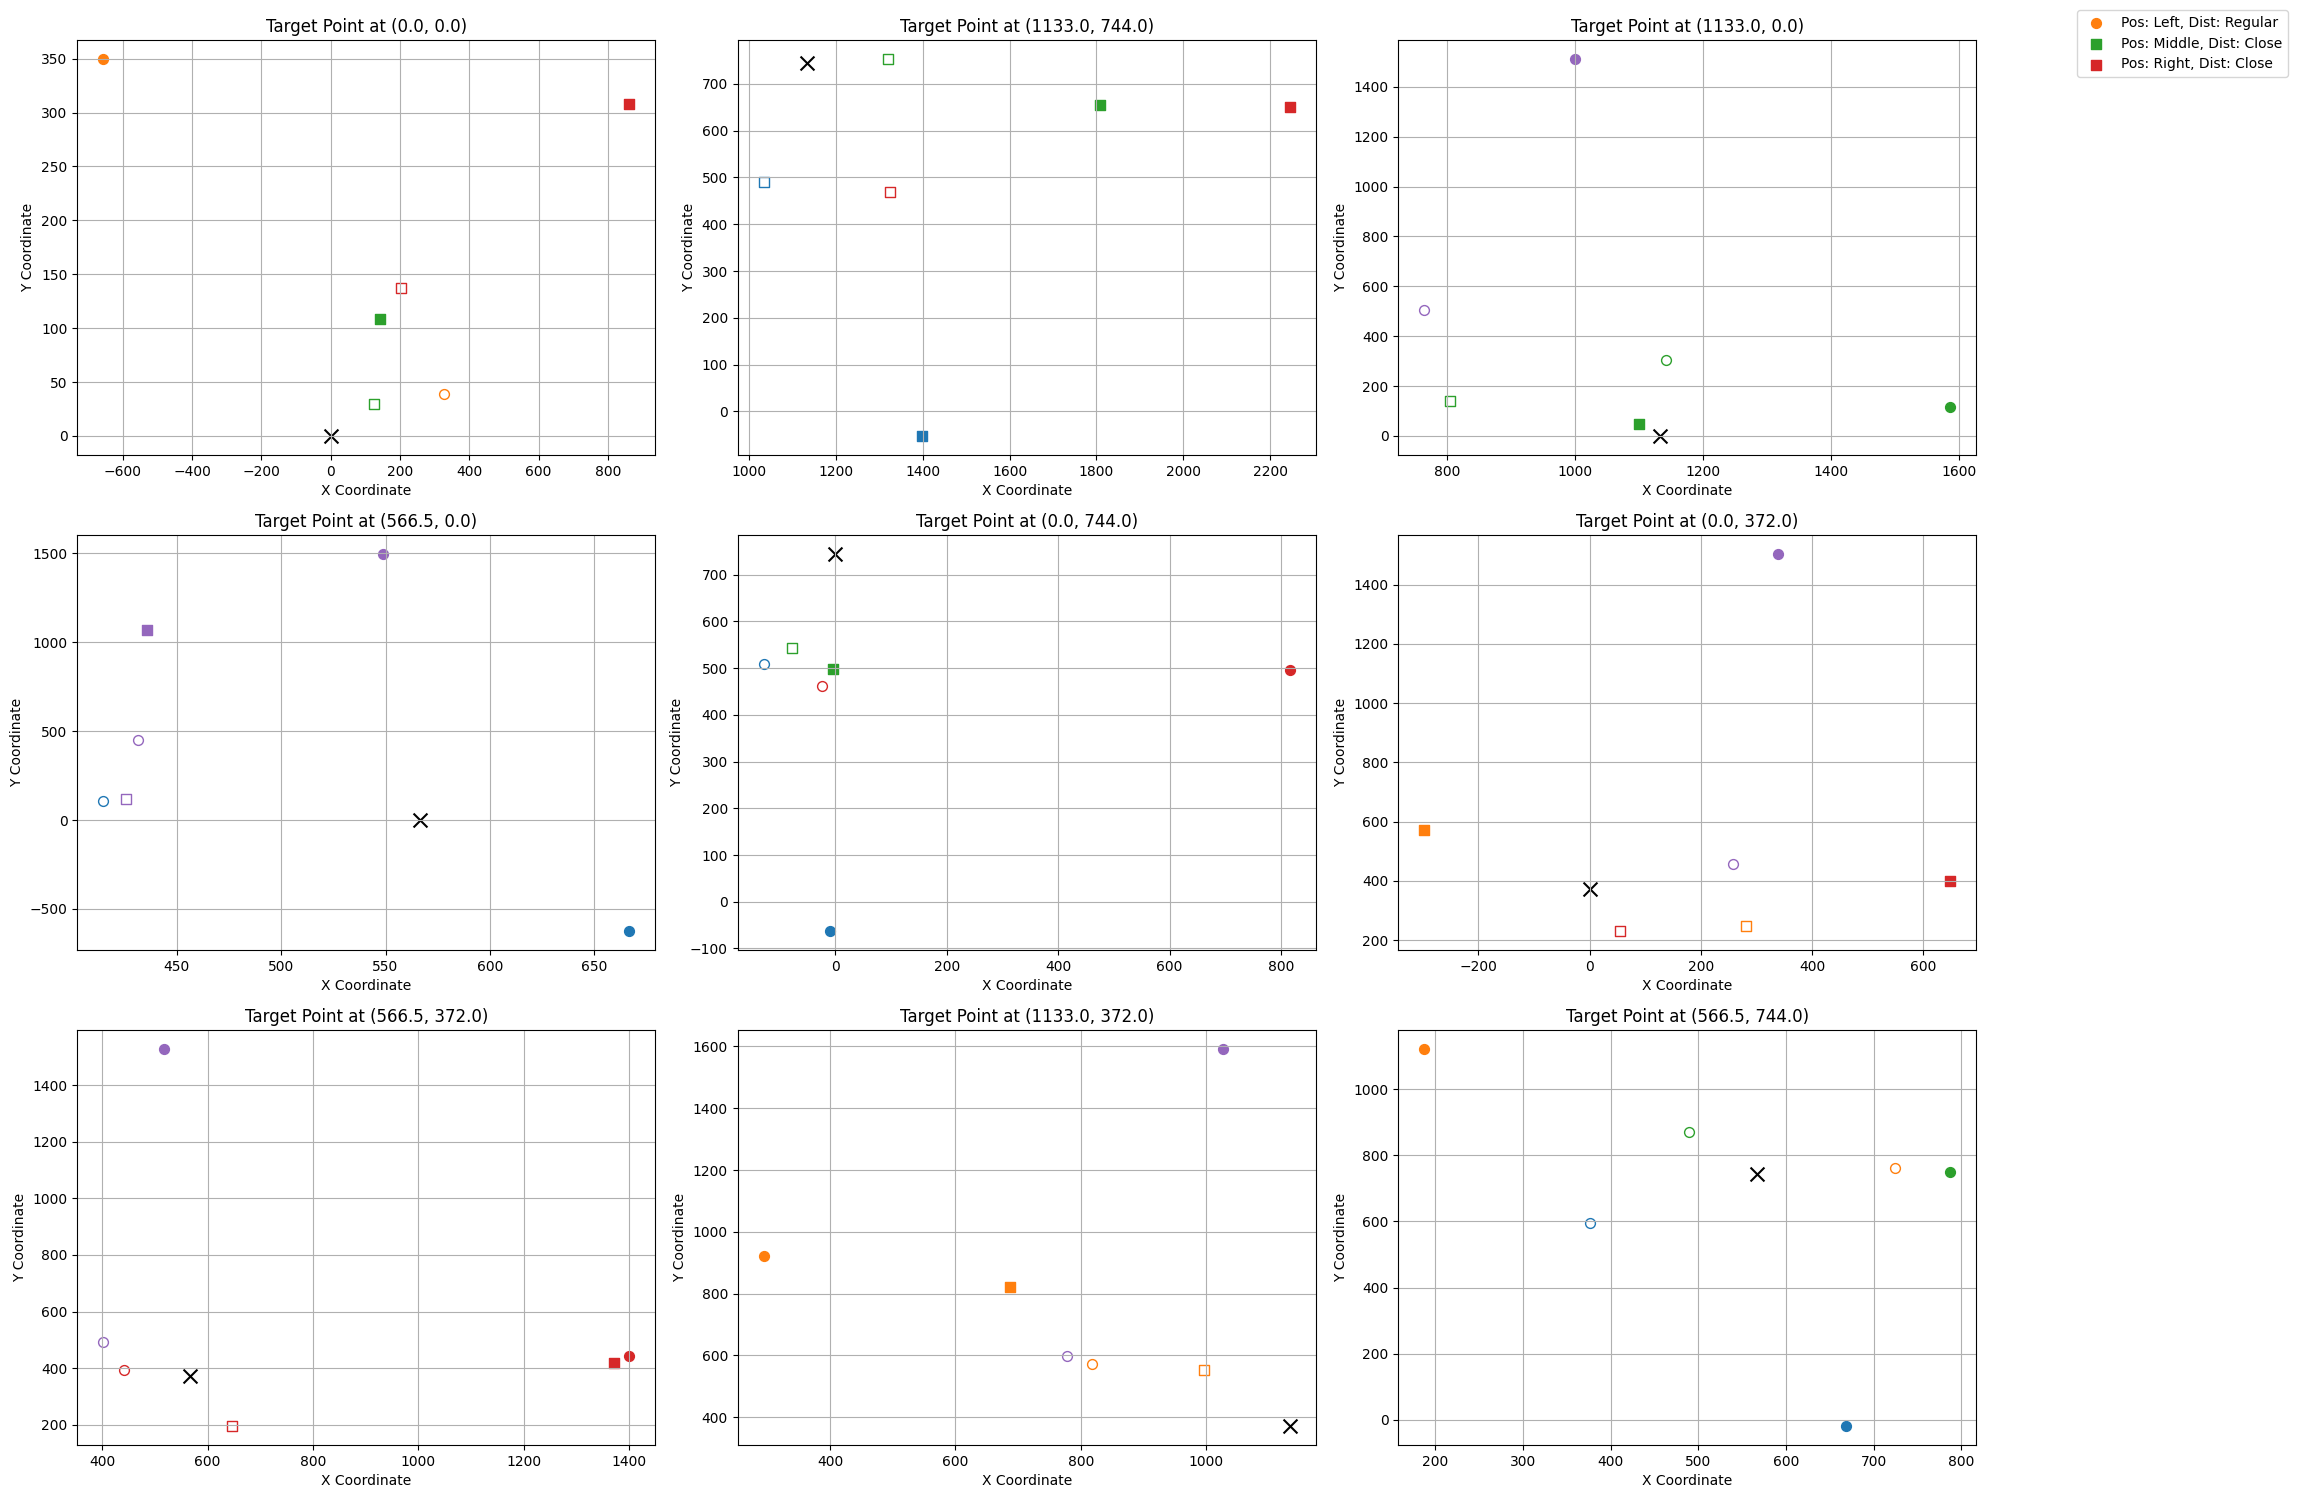

In [33]:
show_subplots(split_rpy_lrc_df, with_calib=True)

##### Test on split data with face transform + roll, pitch and yaw in features

In [ ]:
def features_with_face_and_roll_pitch_yaw(data):
    return (
        list(data.gaze_point)
        + list(data.face_transform.flatten())
        + list(data.euler_angles)
    )

In [ ]:
split_all_lrc = LinearRegressionCalibrator(
    train_data, features_with_face_and_roll_pitch_yaw
)

Let's evaluate on our test set:

In [ ]:
evaluation_all_test = split_all_lrc.evaluate(test_data)
print(evaluation_all_test)

{'MSE': 36027.09634155859, 'RMSE': 189.80805130857485, 'R2': 0.7791381233942303}


In [ ]:
# compare the two (two digit after .2f)
print(f"Difference in MSE:  {evaluation_all_test["MSE"] - evaluation_without_calib["MSE"]:.2f}")
print(f"Difference in RMSE: {evaluation_all_test["RMSE"] - evaluation_without_calib["RMSE"]:.2f}")
print(f"Difference in R2:   {evaluation_all_test["R2"] - evaluation_without_calib["R2"]:.2f}")

Difference in MSE:  -300928.37
Difference in RMSE: -390.67
Difference in R2:   2.51


Now let's compare with features of the entire face transform:  

In [ ]:
# compare the two (two digit after .2f)
print(f"Difference in MSE:  {evaluation_all_test["MSE"] - evaluation_test["MSE"]:.2f}")
print(f"Difference in RMSE: {evaluation_all_test["RMSE"] - evaluation_test["RMSE"]:.2f}")
print(f"Difference in R2:   {evaluation_all_test["R2"] - evaluation_test["R2"]:.2f}")

Difference in MSE:  1976.30
Difference in RMSE: 5.28
Difference in R2:   0.01


In [ ]:
# compare the two (two digit after .2f)
print(f"Difference in MSE:  {evaluation_all_test["MSE"] - evaluation_rpy_test["MSE"]:.2f}")
print(f"Difference in RMSE: {evaluation_all_test["RMSE"] - evaluation_rpy_test["RMSE"]:.2f}")
print(f"Difference in R2:   {evaluation_all_test["R2"] - evaluation_rpy_test["R2"]:.2f}")

Difference in MSE:  -5870.78
Difference in RMSE: -14.88
Difference in R2:   0.11


We can see an improvement in the results calibrated.
Nonetheless, the accuracy is still far from perfect.

In [ ]:
new_columns = test_df.apply(
    lambda row: split_all_lrc.calibrate(
        list((row["gazePointX"], row["gazePointY"]))
        + list(extract_face_transform(row).flatten())
        + list(extract_euler_angles_from_matrix(extract_face_transform(row)))
    ),
    axis=1,
    result_type="expand",
)

# Assign new column names to the resulting DataFrame
new_columns.columns = ["calibratedPointX", "calibratedPointY"]

split_all_lrc_df = pd.concat([test_df, new_columns], axis=1)

display(split_all_lrc_df.head())

,username,deviceName,position,distance,timestamp,targetPointX,targetPointY,gazePointX,gazePointY,faceTransform_0_x,...,leftEyeTransform_3_z,leftEyeTransform_3_w,roll,pitch,yaw,lookAtPointX,lookAtPointY,lookAtPointZ,calibratedPointX,calibratedPointY
0,victor,iPad Mini 6th,Left,Regular,1.715694e+09,0.0,0.0,-655.791091,349.482134,0.800414,...,0.024200,1.0,6.186562,36.734408,-2.859182,0.469521,-0.135954,0.962937,526.041382,23.742933
1,victor,iPad Mini 6th,Middle,Close,1.715694e+09,1133.0,744.0,1808.426258,655.613619,0.999911,...,0.023952,1.0,1.066528,0.759848,0.073083,0.599035,0.164181,0.867825,1291.346026,781.234472
2,victor,iPad Mini 6th,Middle,Regular,1.715694e+09,1133.0,0.0,1586.850165,116.952605,0.999884,...,0.025512,1.0,-0.364283,-0.767425,0.416353,0.208708,-0.061813,0.984702,1162.721280,67.105489
3,victor,iPad Mini 6th,Top,Regular,1.715694e+09,566.5,0.0,548.638776,1493.955594,0.996718,...,0.025155,1.0,33.900023,-2.074320,-4.155998,-0.130180,-0.437656,0.969204,228.036015,367.455850
4,victor,iPad Mini 6th,Down,Regular,1.715694e+09,0.0,744.0,-9.589606,-62.401205,0.999364,...,0.024253,1.0,-14.844797,1.122349,1.697799,-0.190054,0.205339,0.955650,-75.092802,717.315587


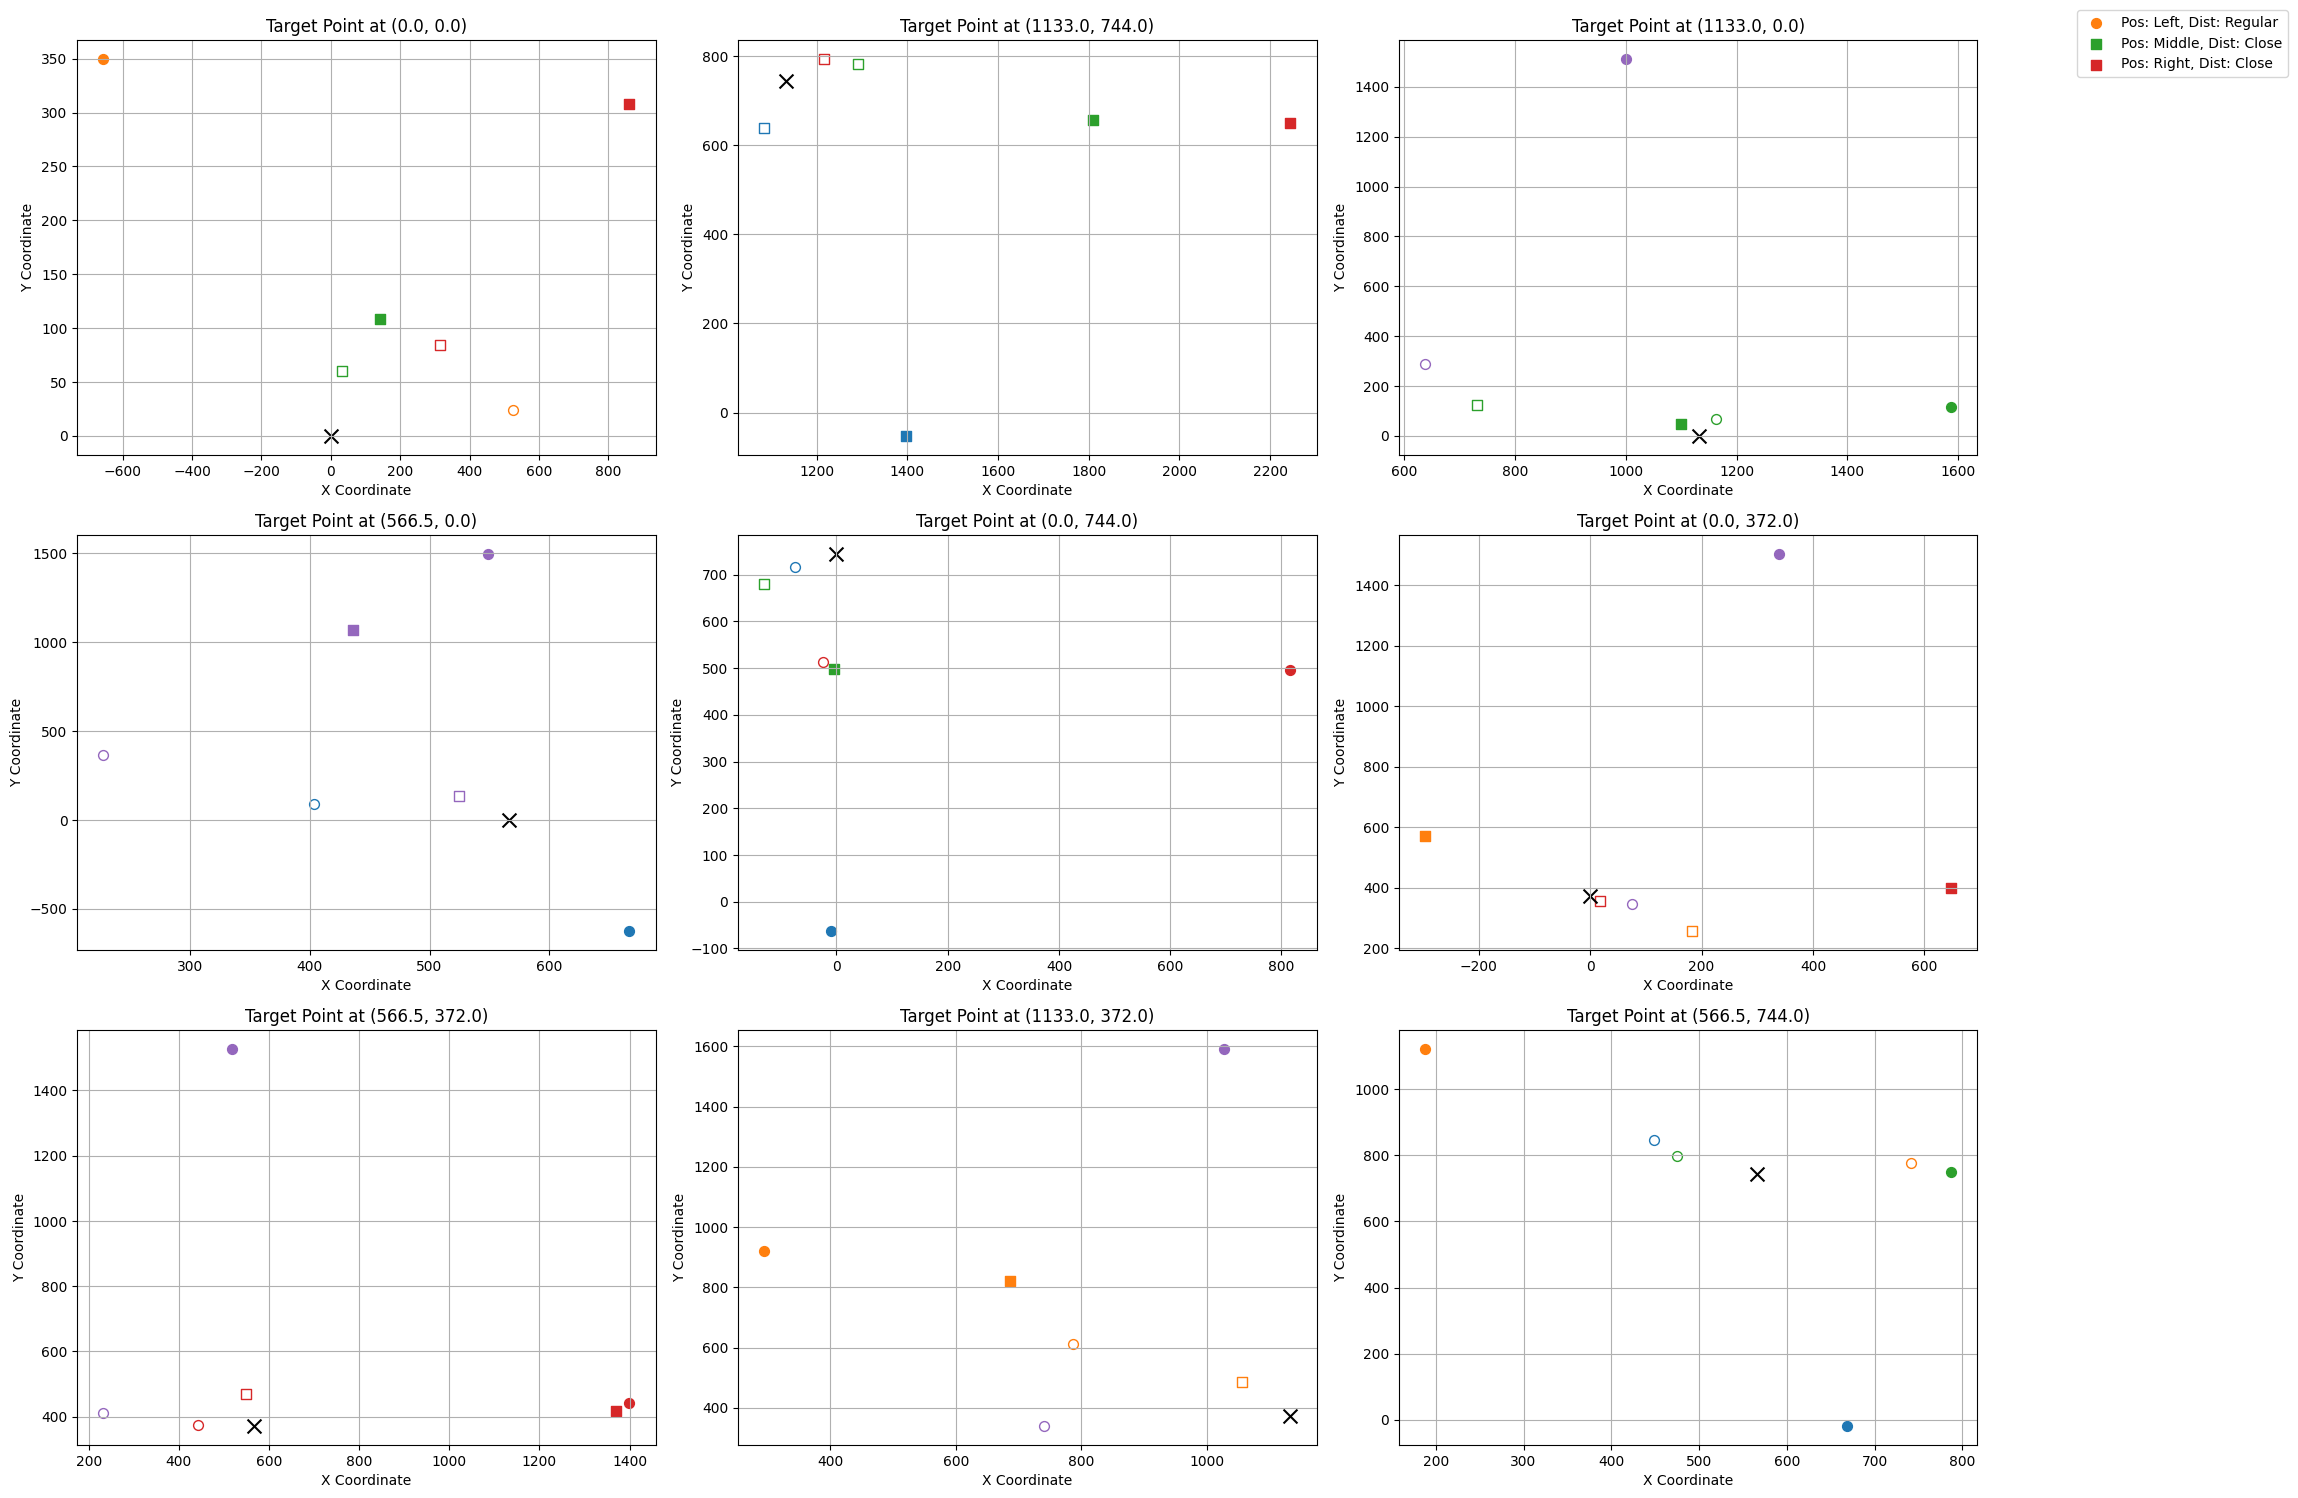

In [ ]:
show_subplots(split_all_lrc_df, with_calib=True)

##### Test on split data with all features

In [42]:
def all_features(data):
    return (
        list(data.gaze_point)
        + list(data.face_transform.flatten())
        + list(data.right_eye_transform.flatten())
        + list(data.euler_angles)
        + list(data.look_at_point)
    )

In [43]:
split_all_lrc = LinearRegressionCalibrator(train_data, all_features)

Let's evaluate on our test set:

In [44]:
evaluation_all_test = split_all_lrc.evaluate(test_data)
print(evaluation_all_test)

{'MSE': 39976.29605294591, 'RMSE': 199.9407313504327, 'R2': 0.7632787228461599}


In [45]:
# compare the two (two digit after .2f)
print(f"Difference in MSE:  {evaluation_all_test["MSE"] - evaluation_without_calib["MSE"]:.2f}")
print(f"Difference in RMSE: {evaluation_all_test["RMSE"] - evaluation_without_calib["RMSE"]:.2f}")
print(f"Difference in R2:   {evaluation_all_test["R2"] - evaluation_without_calib["R2"]:.2f}")

Difference in MSE:  -296979.17
Difference in RMSE: -380.54
Difference in R2:   2.49


Now let's compare with features of the entire face transform:  

In [46]:
# compare the two (two digit after .2f)
print(f"Difference in MSE:  {evaluation_all_test["MSE"] - evaluation_test["MSE"]:.2f}")
print(f"Difference in RMSE: {evaluation_all_test["RMSE"] - evaluation_test["RMSE"]:.2f}")
print(f"Difference in R2:   {evaluation_all_test["R2"] - evaluation_test["R2"]:.2f}")

Difference in MSE:  5925.50
Difference in RMSE: 15.41
Difference in R2:   -0.01


In [47]:
# compare the two (two digit after .2f)
print(f"Difference in MSE:  {evaluation_all_test["MSE"] - evaluation_rpy_test["MSE"]:.2f}")
print(f"Difference in RMSE: {evaluation_all_test["RMSE"] - evaluation_rpy_test["RMSE"]:.2f}")
print(f"Difference in R2:   {evaluation_all_test["R2"] - evaluation_rpy_test["R2"]:.2f}")

Difference in MSE:  -1921.58
Difference in RMSE: -4.75
Difference in R2:   0.09


We can see an improvement in the results calibrated.
Nonetheless, the accuracy is still far from perfect.

In [49]:
new_columns = test_df.apply(
    lambda row: split_all_lrc.calibrate(
        list((row["gazePointX"], row["gazePointY"]))
        + list(extract_face_transform(row).flatten())
        + list(extract_face_transform(row, type="rightEyeTransform").flatten())
        + list(extract_euler_angles_from_matrix(extract_face_transform(row)))
        + list(row[["lookAtPointX", "lookAtPointY", "lookAtPointZ"]])
    ),
    axis=1,
    result_type="expand",
)

# Assign new column names to the resulting DataFrame
new_columns.columns = ["calibratedPointX", "calibratedPointY"]

split_all_lrc_df = pd.concat([test_df, new_columns], axis=1)

display(split_all_lrc_df.head())

,username,deviceName,position,distance,timestamp,targetPointX,targetPointY,gazePointX,gazePointY,faceTransform_0_x,...,leftEyeTransform_3_z,leftEyeTransform_3_w,roll,pitch,yaw,lookAtPointX,lookAtPointY,lookAtPointZ,calibratedPointX,calibratedPointY
0,victor,iPad Mini 6th,Left,Regular,1.715694e+09,0.0,0.0,-655.791091,349.482134,0.800414,...,0.024200,1.0,6.186562,36.734408,-2.859182,0.469521,-0.135954,0.962937,-324.018888,168.248338
1,victor,iPad Mini 6th,Middle,Close,1.715694e+09,1133.0,744.0,1808.426258,655.613619,0.999911,...,0.023952,1.0,1.066528,0.759848,0.073083,0.599035,0.164181,0.867825,1758.459499,685.055019
2,victor,iPad Mini 6th,Middle,Regular,1.715694e+09,1133.0,0.0,1586.850165,116.952605,0.999884,...,0.025512,1.0,-0.364283,-0.767425,0.416353,0.208708,-0.061813,0.984702,1268.544161,22.621313
3,victor,iPad Mini 6th,Top,Regular,1.715694e+09,566.5,0.0,548.638776,1493.955594,0.996718,...,0.025155,1.0,33.900023,-2.074320,-4.155998,-0.130180,-0.437656,0.969204,157.730890,299.332750
4,victor,iPad Mini 6th,Down,Regular,1.715694e+09,0.0,744.0,-9.589606,-62.401205,0.999364,...,0.024253,1.0,-14.844797,1.122349,1.697799,-0.190054,0.205339,0.955650,-217.485735,602.065913


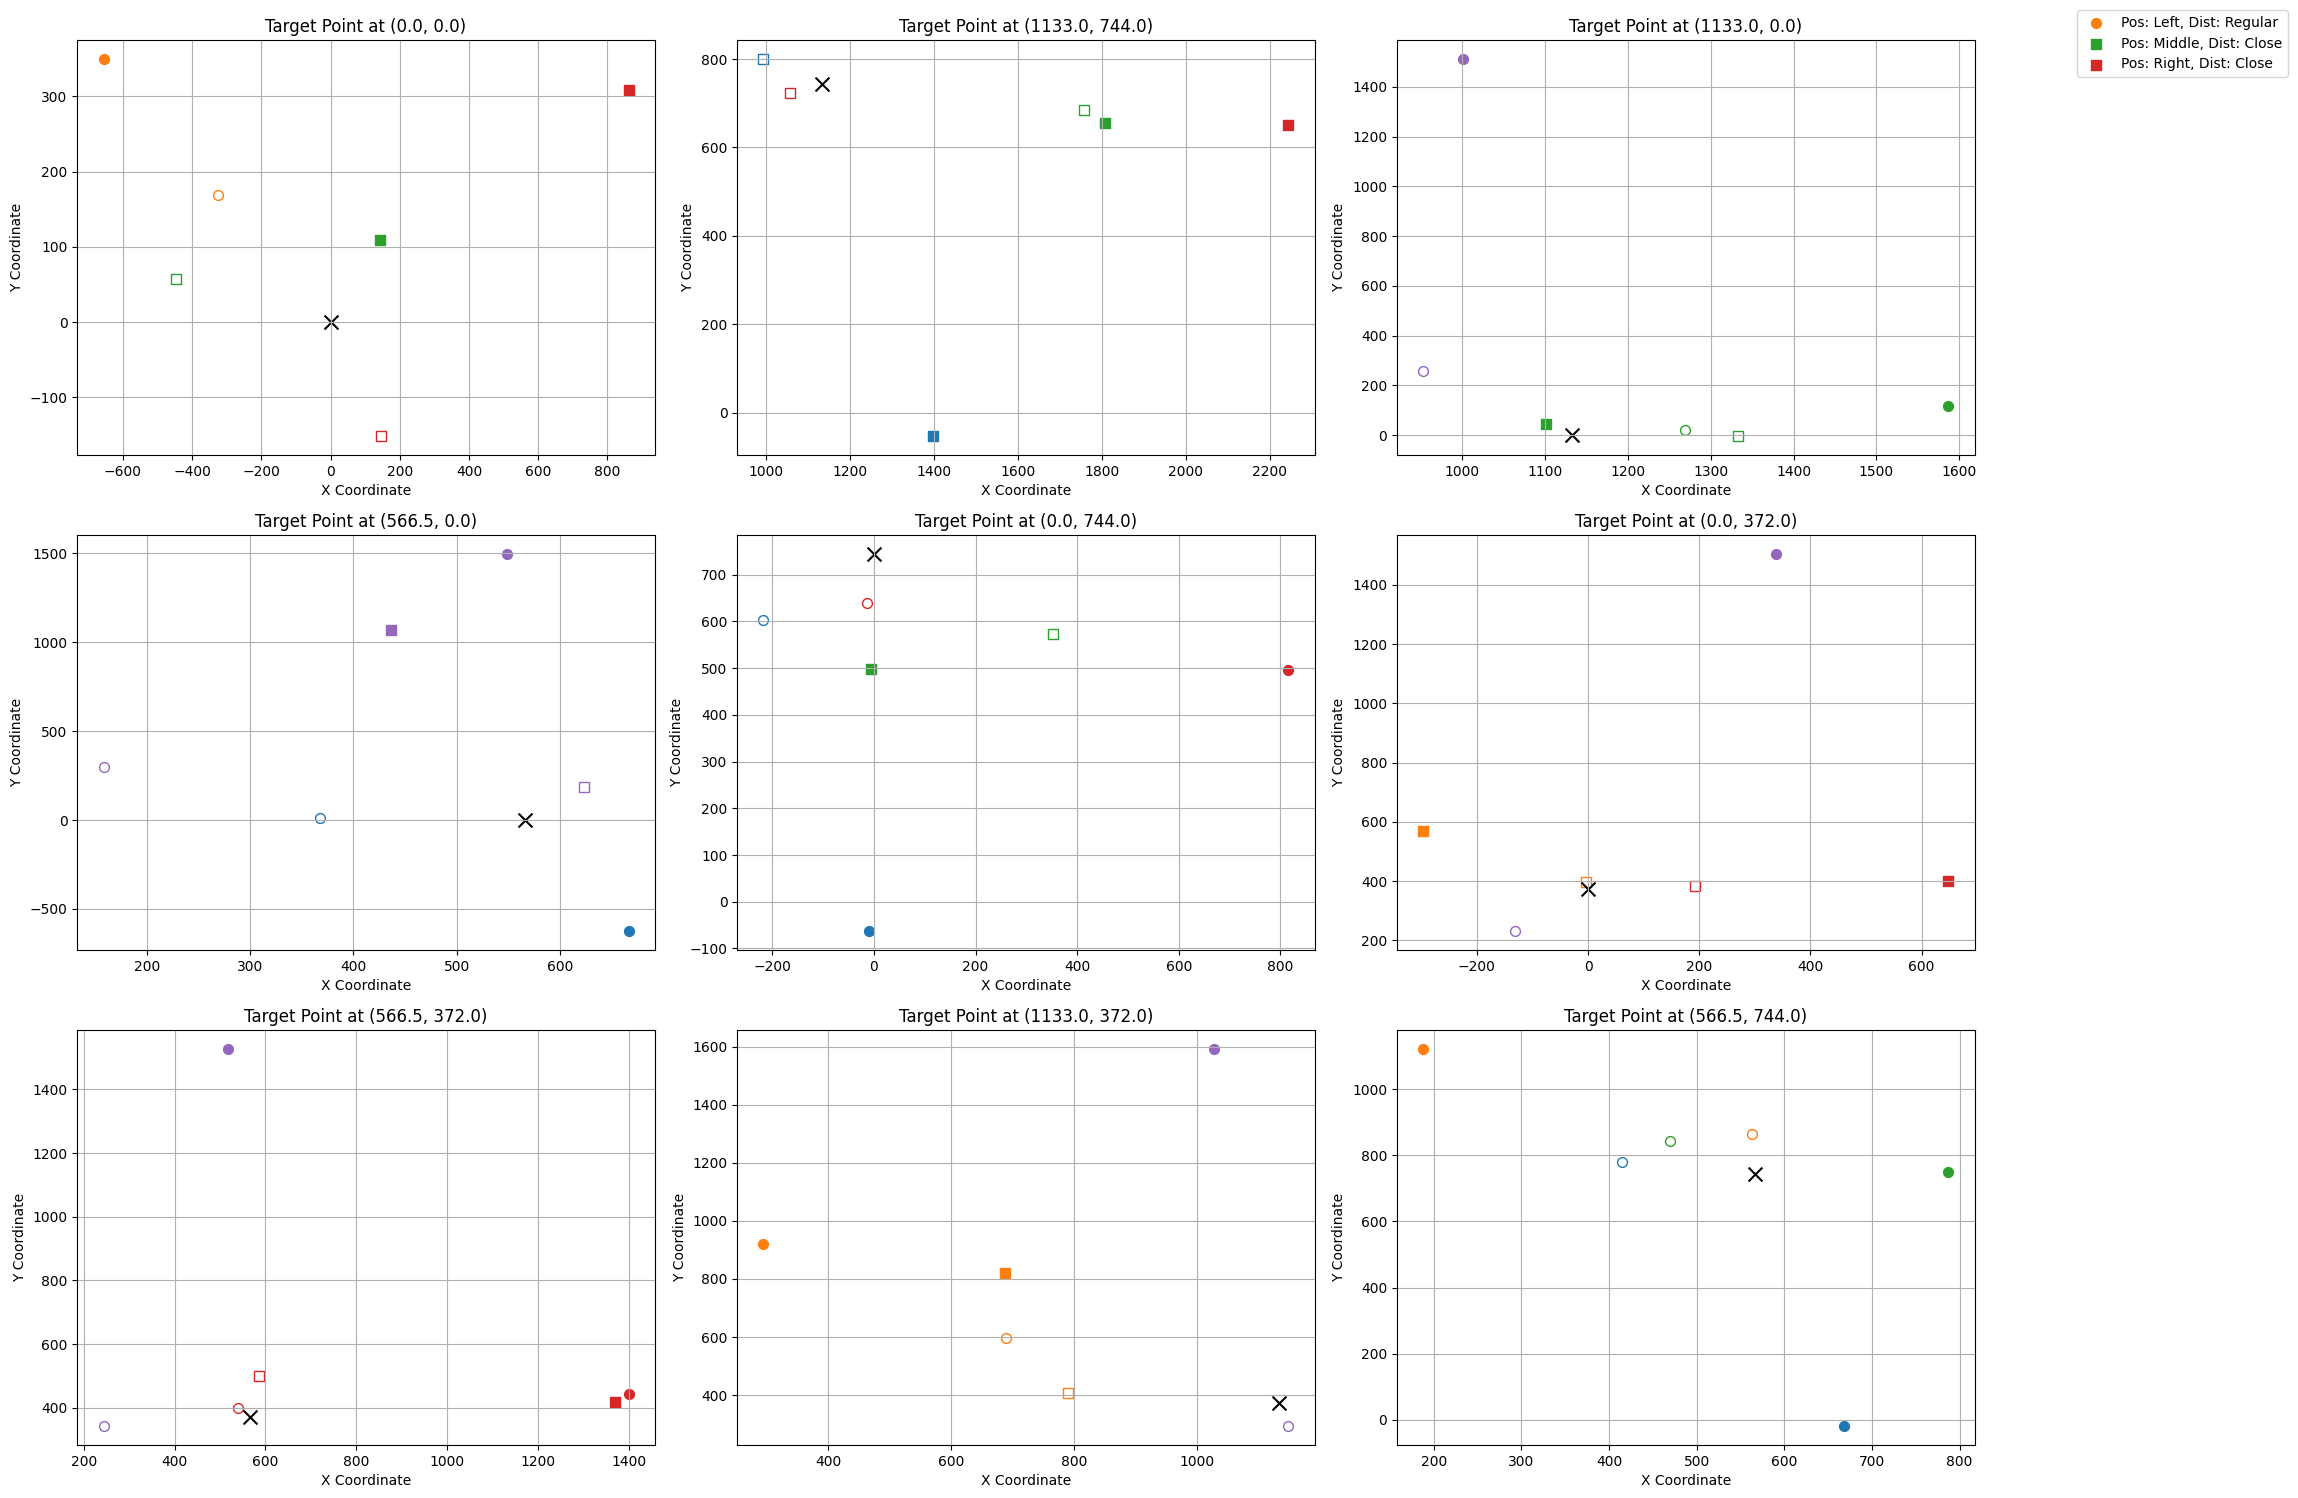

In [51]:
show_subplots(split_all_lrc_df, with_calib=True)